<a href="https://colab.research.google.com/github/2hwa-jang/kakao-present-analysis/blob/main/%5BPJ%5D_Kakao_Present_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 카카오톡 선물하기 리뷰 분석

**데이터 수집 대상**
- 대상 : 카카오톡 선물하기 상품 및 리뷰 정보
- 표본 : 많이 선물한 TOP 100개 배송 상품에 대해 각 200개의 리뷰 랜덤 선정 추출 (총 20000여개)
---
**RQ : 관계적 특성이 리뷰 내용과 만족도에 영향을 미치는가?**

---
- 리뷰 텍스트에 pre-trained 된 감성 분류 모델을 적용, 60개 감정 중 몇 개를 포함하는지 확인
- 사용자가 남긴 리뷰 평점과 결합하여 리뷰의 종합 만족도를 계산

## [1] 전처리

In [ ]:
# 한글 깨짐 방지
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (6,156 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 123632 files and dire

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install koreanize-matplotlib
!apt-get update -qq
!apt-get install fonts-nanum* -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 53.7 MB/s eta 0:00:00
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum-coding.
(Reading database ... 123655 files and directories currently installed.)
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-coding (2.5-3) ...
Setting up fonts-nanum-eco (1.000-7) ...
Processing triggers for fontconfig (2.13.1-4

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager as fm
font_name = fm.FontProperties(fname='/usr/share/fonts/truetype/nanum/NanumGothic.ttf').get_name()
plt.rc('font', family=font_name)

In [ ]:
import koreanize_matplotlib

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from transformers import pipeline

In [ ]:
# 데이터 로드

# 파일 경로
file_path = '/content/drive/MyDrive/Business Analytics 석사/24-2 [수업] 비즈니스 머신러닝/'

# 파일 로드
df = pd.read_excel(file_path + 'review-ALL.xlsx')

In [ ]:
df.head()

,ID,Title,Image,ico_detail,View,View1,Keywords,Info,Description,Description3,Description4,Description5,ico_detail6,Page_URL
0,1,"봄 지나 여름, 여름 지나 가을이 오고 부쩍 날이 쌀쌀해진 요즘 몸이 허해진 찰나 ...",https://gift-s.kakaocdn.net/dn/gift/gift/con.png,별점 4점 만점 중 4점,다정한 콘,2023.09.15,#제자에게 받은\n#반려동물 선물,"총 1,417명이 공감했어요!","재미있어요\n공감수 :\n1,247\n개,","감동이에요\n공감수 :\n87\n개,","받고 싶어요\n공감수 :\n47\n개,","속상해요\n공감수 :\n36\n개,",리뷰 관련 메뉴,https://gift.kakao.com/product/2301047?tab=rev...
1,2,훈련간 아들이 보내준 선물.\n감동+감동~\n빨리 나을게^^,https://gift-s.kakaocdn.net/dn/gift/gift/tube.png,별점 4점 만점 중 4점,기뻐하는 튜브,2023.07.31,#부모님에게 받은\n#위로 선물,총 95명이 공감했어요!,"감동이에요\n공감수 :\n81\n개,","받고 싶어요\n공감수 :\n7\n개,","속상해요\n공감수 :\n5\n개,","재미있어요\n공감수 :\n2\n개,",리뷰 관련 메뉴,https://gift.kakao.com/product/2301047?tab=rev...
2,3,"포장고급스럽다하는데 걍 부직포인데,,키링에 오쏘몰 대문짝만하게 있어서 달고다니면 오...",https://gift-s.kakaocdn.net/dn/gift/gift/apeac...,별점 4점 만점 중 3점,행복한 어피치,2023.12.28,#친구에게 받은\n#응원 선물,총 37명이 공감했어요!,"재미있어요\n공감수 :\n25\n개,","속상해요\n공감수 :\n8\n개,","감동이에요\n공감수 :\n2\n개,","받고 싶어요\n공감수 :\n2\n개,",리뷰 관련 메뉴,https://gift.kakao.com/product/2301047?tab=rev...
3,4,"우리팀의 보배 김대리님~♡\n입사한지 이제 100일 정도 되었는데,\n일 잘하는것도...",https://p.kakaocdn.net/th/talkp/wo9jhOMK05/8rp...,별점 4점 만점 중 4점,유영미,2024.02.07,#직장동료에게 받은\n#생일 선물,총 22명이 공감했어요!,"감동이에요\n공감수 :\n15\n개,","받고 싶어요\n공감수 :\n6\n개,","재미있어요\n공감수 :\n1\n개,","속상해요\n공감수 :\n0\n개,",리뷰 관련 메뉴,https://gift.kakao.com/product/2301047?tab=rev...
4,5,체력이 딸려서 힘들 때마다 먹고있어요. 요단강에 발 담구고 있는데 현실 세계로 멱살...,https://gift-s.kakaocdn.net/dn/gift/gift/ryan.png,별점 4점 만점 중 4점,다정한 라이언,2023.02.01,#친구에게 받은\n#생일 선물,총 395명이 공감했어요!,"재미있어요\n공감수 :\n338\n개,","감동이에요\n공감수 :\n22\n개,","속상해요\n공감수 :\n18\n개,","받고 싶어요\n공감수 :\n17\n개,",리뷰 관련 메뉴,https://gift.kakao.com/product/2301047?tab=rev...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22358 entries, 0 to 22357
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            22358 non-null  int64 
 1   Title         22358 non-null  object
 2   Image         22358 non-null  object
 3   ico_detail    22357 non-null  object
 4   View          22358 non-null  object
 5   View1         22358 non-null  object
 6   Keywords      22358 non-null  object
 7   Info          13458 non-null  object
 8   Description   13458 non-null  object
 9   Description3  13458 non-null  object
 10  Description4  13458 non-null  object
 11  Description5  13458 non-null  object
 12  ico_detail6   22358 non-null  object
 13  Page_URL      22358 non-null  object
dtypes: int64(1), object(13)
memory usage: 2.4+ MB


In [ ]:
# 불필요한 컬럼 삭제
df = df.drop(columns=['Image', 'Description', 'Description3', 'Description4', 'Description5', 'ico_detail6', 'Page_URL'], errors='ignore')

In [ ]:
# 정규식을 사용해 별점에서 Y점(뒤에서 두 번째 숫자)을 추출
df['ico_detail'] = df['ico_detail'].str.extract(r'만점 중 (\d)점')[0]

In [ ]:
# Keywords 컬럼: # 뒤에부터 ‘에게’ 앞까지만 살리기
df['Keywords'] = df['Keywords'].str.extract(r'#(.*?)에게')

In [ ]:
# Info 컬럼: 공감한 사람 수 (숫자만 추출)
# Info 컬럼: NaN 값을 0으로 대체하고 숫자만 추출
df['Info'] = df['Info'].fillna('0').str.replace(r'[^0-9]', '', regex=True).astype(int)

In [ ]:
df.head()

,ID,Title,ico_detail,View,View1,Keywords,Info
0,1,"봄 지나 여름, 여름 지나 가을이 오고 부쩍 날이 쌀쌀해진 요즘 몸이 허해진 찰나 ...",4,다정한 콘,2023.09.15,제자,1417
1,2,훈련간 아들이 보내준 선물.\n감동+감동~\n빨리 나을게^^,4,기뻐하는 튜브,2023.07.31,부모님,95
2,3,"포장고급스럽다하는데 걍 부직포인데,,키링에 오쏘몰 대문짝만하게 있어서 달고다니면 오...",3,행복한 어피치,2023.12.28,친구,37
3,4,"우리팀의 보배 김대리님~♡\n입사한지 이제 100일 정도 되었는데,\n일 잘하는것도...",4,유영미,2024.02.07,직장동료,22
4,5,체력이 딸려서 힘들 때마다 먹고있어요. 요단강에 발 담구고 있는데 현실 세계로 멱살...,4,다정한 라이언,2023.02.01,친구,395


In [ ]:
# 컬럼명 변경
df.rename(columns={
    'ico_detail': 'score',
    'View': 'username',
    'View1': 'date',
    'Keywords': 'giver',
    'Info': 'review_likes'
}, inplace=True)

In [ ]:
df.head()

,ID,Title,score,username,date,giver,review_likes
0,1,"봄 지나 여름, 여름 지나 가을이 오고 부쩍 날이 쌀쌀해진 요즘 몸이 허해진 찰나 ...",4,다정한 콘,2023.09.15,제자,1417
1,2,훈련간 아들이 보내준 선물.\n감동+감동~\n빨리 나을게^^,4,기뻐하는 튜브,2023.07.31,부모님,95
2,3,"포장고급스럽다하는데 걍 부직포인데,,키링에 오쏘몰 대문짝만하게 있어서 달고다니면 오...",3,행복한 어피치,2023.12.28,친구,37
3,4,"우리팀의 보배 김대리님~♡\n입사한지 이제 100일 정도 되었는데,\n일 잘하는것도...",4,유영미,2024.02.07,직장동료,22
4,5,체력이 딸려서 힘들 때마다 먹고있어요. 요단강에 발 담구고 있는데 현실 세계로 멱살...,4,다정한 라이언,2023.02.01,친구,395


(+) 추가 전처리 필요 사항
- username 기준으로 익명 작성자인지 실명 작성자인지 구분해야 함
- 선물 준 사람과 수령인의 관계 (수직적 vs. 수평적 vs. 자기 선물) 라벨링
  - 기존 카카오톡 선물하기에서 제안하는 관계 종류 : 친구, 연인, 썸, 형제/자매, 선/후배, 직장동료, 자녀, 부모님, 제자, 선생님, 기타

In [ ]:
giver_array = df.giver.unique()

In [ ]:
len(giver_array)

545

In [ ]:
giver_array

array(['제자', '부모님', '친구', '직장동료', '자녀', '썸', '조카', '선/후배', '형제/자매', '지인',
       '완전좋아하는쌤', '선생님', '연인', '나', '조카한테서받았', '멀리있는', '동기', '매형', '설선물',
       '아들여자친구', '김사', '친척', '자기', '건강', '동기목사님', '성당지인', '제부', '교회',
       '전직장동료', '오쏘몰바이탈', '비타민', '생일선물', '올케', '지인분', '생일선물최고에요', '주인',
       '연말', '면역엔이뮨', '힘내라부모님', '남자친구', '다영T가16기', '엄마선물', '이모', '사랑스러운',
       '제자부모', '명품은백화서사', '감동', '고모', '찌니어스이모들', '가족', '아는동생', '직원생일선물',
       '립그로스', '남편', '직장상사안사람', '딸남친', '작은아버지', '명절선물', '아들친구엄마', '이쁜조카',
       '아들이보내주었', '푸드장프리미엄ㅅ', '딸래미남친', '고기', '거래처', '사촌언니', '학부모님', '조카딸',
       '기이타', 'ㅎㅎㅎ', '새언니', '동료', 'ㅇ', '생일케익', '학부모', '교회목사님', '생일선물감사',
       '형부', '25598850', '교회부장쌤', '학교', '모임동생', '아들', '함께익어갈사람', '딸',
       '이모선물', '선물', '팬분', '의미있는선물', '친구맘', '이쁜올케', '외숙모', '시댁조카',
       '지인입니다', '언니', '시누이선물', '감사선물', '아가씨', '애플망고', '고당도애플망고', '윗집',
       '딸의고마운분', '목사님사모님', '열일제목없음', '형님께선물', '남자친구부모님', '고마운마음',
       '스포츠동호인모임', '딸냄남자친구', '잘먹겠습니다', '농협안심별로', '사위', '소고기', '군대간조

In [ ]:
# 범주 매핑 딕셔너리
categories = {
    '나' : ['나'],
    '친구': ['친구', '절친', '친구가선물'],
    '연인': ['연인', '남자친구', '여자친구'],
    '썸': ['썸'],
    '형제/자매': ['형제/자매', '형제', '형', '누나', '언니', '오빠', '동생'],
    '선/후배': ['선/후배', '선배', '후배', '동기', '선후배'],
    '직장동료': ['직장동료', '회사동료', '전직장동료', '동료'],
    '자녀': ['자녀'],
    '부모님': ['부모님'],
    '제자': ['제자', '학생'],
    '선생님': ['선생님', '스승', '스승님', '학교선생님']
}

# 범주 매핑 함수
def map_giver_category(giver):
    for category, keywords in categories.items():
        if any(keyword in str(giver) for keyword in keywords):
            return category
    return '기타'  # 매칭되지 않으면 기타로 처리

# giver 값을 범주로 매핑
df['giver'] = df['giver'].apply(map_giver_category)

# 카운트 계산
giver_counts = df['giver'].value_counts()

# 결과 출력
print(giver_counts)

giver
친구       9926
직장동료     2753
형제/자매    2514
나        2076
선/후배     1823
기타        890
자녀        829
연인        649
선생님       321
제자        248
부모님       238
썸          91
Name: count, dtype: int64


#### [1]-1 관계 라벨링 **`giver_label`**

- 수직적 관계 : 선/후배, 직장동료, 선생님, 제자 **`vertical`**
- 수평적 관계 : 친구, 연인, 썸, 형제/자매 **`horizontal`**
- 자기 선물 : 나 **`self`**
- 애매 : 자녀, 부모님, 기타 (분석에서 제외 예정)


In [ ]:
# 관계 라벨링 기준 정의
relation_mapping = {
    '선/후배': 'vertical',
    '직장동료': 'vertical',
    '선생님': 'vertical',
    '제자': 'vertical',
    '친구': 'horizontal',
    '연인': 'horizontal',
    '썸': 'horizontal',
    '형제/자매': 'horizontal',
    '나': 'self',
    '자녀': 'etc',
    '부모님': 'etc',
    '기타': 'etc'
}

# giver_label 컬럼 생성
df['giver_label'] = df['giver'].map(relation_mapping)

In [ ]:
# 결과 확인
df[['giver', 'giver_label']]

,giver,giver_label
0,제자,vertical
1,부모님,etc
2,친구,horizontal
3,직장동료,vertical
4,친구,horizontal
...,...,...
22353,직장동료,vertical
22354,친구,horizontal
22355,친구,horizontal
22356,직장동료,vertical


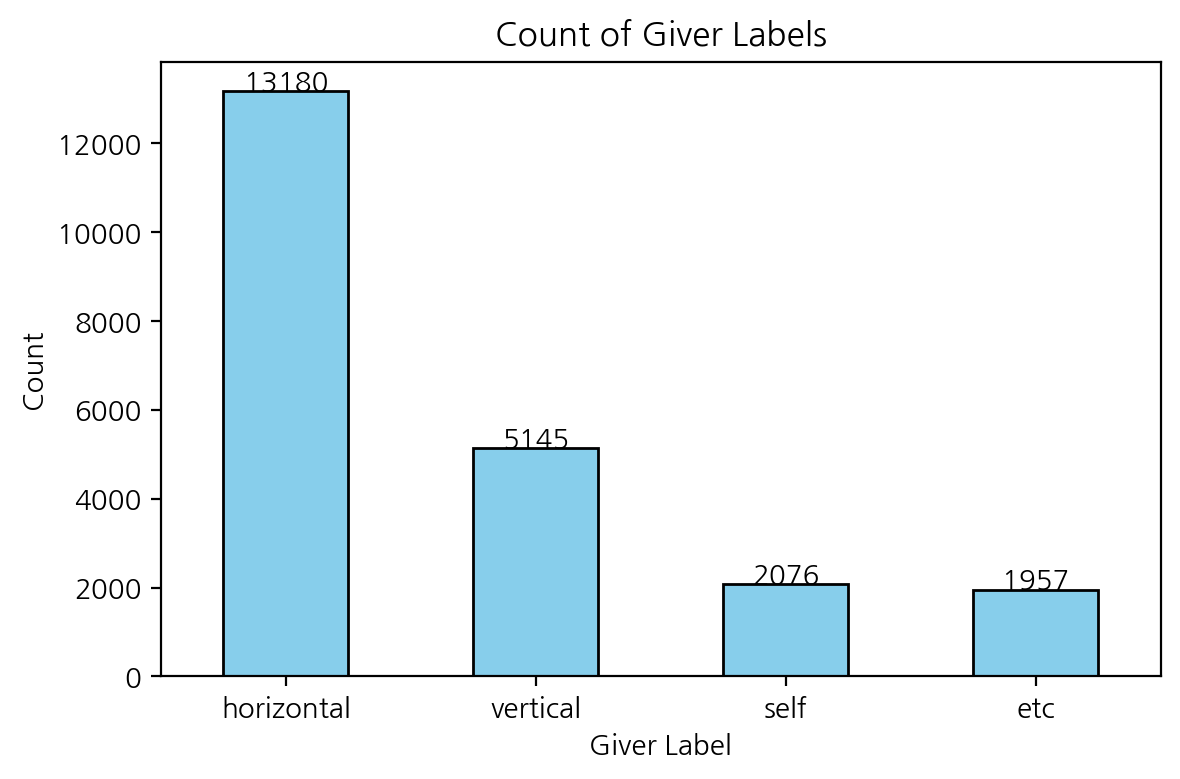

In [ ]:
# giver_label 값의 개수 계산
label_counts = df['giver_label'].value_counts()

# 막대그래프 생성
plt.figure(figsize=(6, 4))  # 그래프 크기 설정
label_counts.plot(kind='bar', rot=0, color='skyblue', edgecolor='black')

# 그래프 제목 및 축 레이블 설정
plt.title('Count of Giver Labels', fontsize=12)
plt.xlabel('Giver Label', fontsize=10)
plt.ylabel('Count', fontsize=10)

# 값 표시
for i, count in enumerate(label_counts):
    plt.text(i, count + 0.5, str(count), ha='center', fontsize=10)

# 그래프 출력
plt.tight_layout()
plt.show()


* 데이터의 불균형 어떻게 처리할 것인지 논의 필요

#### [1]-2 익명 작성자 구분

In [ ]:
# 익명 캐릭터 목록
anonymous_characters = ['라이언', '어피치', '튜브', '콘', '무지', '프로도', '네오', '제이지', '앙몬드', '죠르디']

# 익명/실명 구분 함수
def classify_anonymity(username):
    # username이 익명 캐릭터로 끝나는 경우
    if any(username.endswith(char) for char in anonymous_characters):
        return '익명'
    else:
        return '실명'

# anonymity 열 생성
df['anonymity'] = df['username'].apply(classify_anonymity)

In [ ]:
# 결과 확인
df[['username', 'anonymity']].head()

,username,anonymity
0,다정한 콘,익명
1,기뻐하는 튜브,익명
2,행복한 어피치,익명
3,유영미,실명
4,다정한 라이언,익명


In [ ]:
df

,ID,Title,score,username,date,giver,review_likes,giver_label,anonymity
0,1,"봄 지나 여름, 여름 지나 가을이 오고 부쩍 날이 쌀쌀해진 요즘 몸이 허해진 찰나 ...",4,다정한 콘,2023.09.15,제자,1417,vertical,익명
1,2,훈련간 아들이 보내준 선물.\n감동+감동~\n빨리 나을게^^,4,기뻐하는 튜브,2023.07.31,부모님,95,etc,익명
2,3,"포장고급스럽다하는데 걍 부직포인데,,키링에 오쏘몰 대문짝만하게 있어서 달고다니면 오...",3,행복한 어피치,2023.12.28,친구,37,horizontal,익명
3,4,"우리팀의 보배 김대리님~♡\n입사한지 이제 100일 정도 되었는데,\n일 잘하는것도...",4,유영미,2024.02.07,직장동료,22,vertical,실명
4,5,체력이 딸려서 힘들 때마다 먹고있어요. 요단강에 발 담구고 있는데 현실 세계로 멱살...,4,다정한 라이언,2023.02.01,친구,395,horizontal,익명
...,...,...,...,...,...,...,...,...,...
22353,22354,선물받은 제품 잘먹을께요,4,활기찬 라이언,2024.08.23,직장동료,0,vertical,익명
22354,22355,포장 예쁘구 원하던 제품 받아서 기분 너무 좋아요. 빨리 먹구 건강 챙길께요,4,ㅇㅇ,2024.08.23,친구,0,horizontal,실명
22355,22356,처음 받아보는 선물입니다\n잘 먹고 건강하겠습니다~,4,다정한 튜브,2024.08.23,친구,0,horizontal,익명
22356,22357,먹고 건강챙기라 선물받았어요.\n먹어보고 효과좋음 꾸준히 먹어보려구요.\n구성 좋네요,4,친절한 어피치,2024.08.22,직장동료,0,vertical,익명


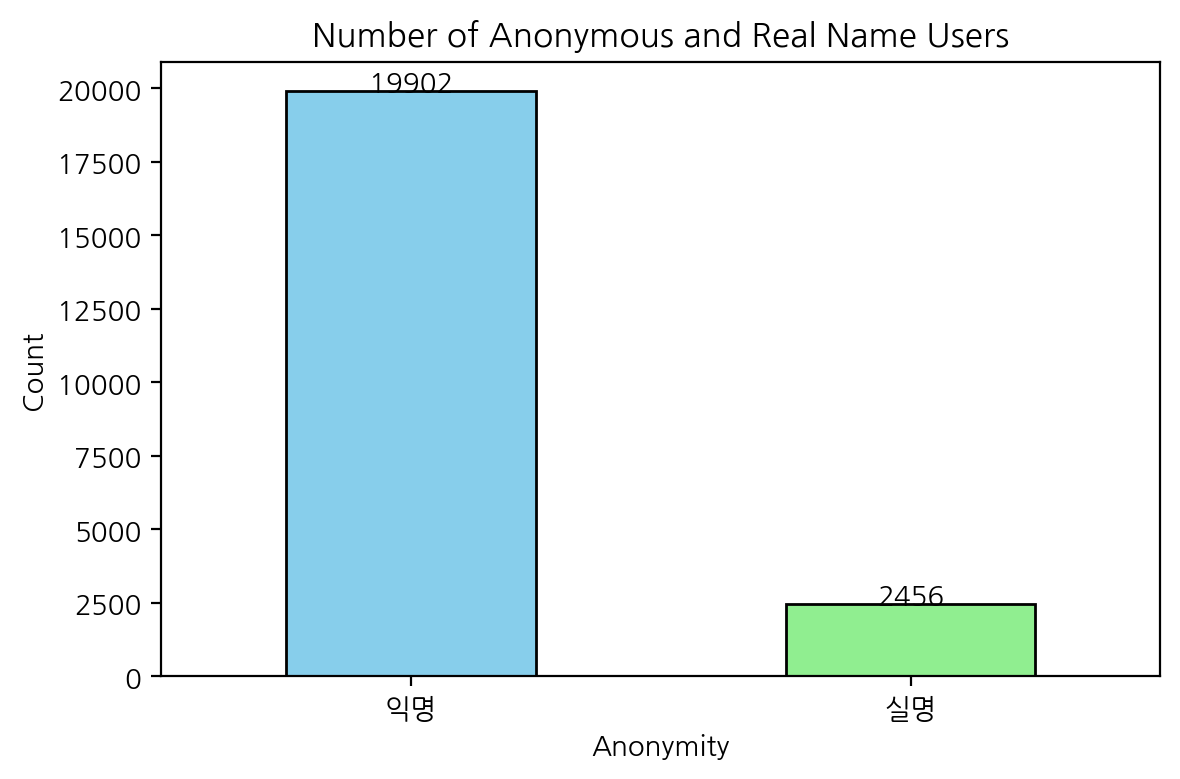

In [ ]:
# 실명, 익명 작성자 수 막대그래프

# 실명, 익명 작성자 수 계산
anonymity_counts = df['anonymity'].value_counts()

# 막대그래프 생성
plt.figure(figsize=(6, 4))  # 그래프 크기 설정
anonymity_counts.plot(kind='bar', color=['skyblue', 'lightgreen'], edgecolor='black', rot=0)

# 그래프 제목 및 축 레이블 설정
plt.title('Number of Anonymous and Real Name Users', fontsize=12)
plt.xlabel('Anonymity', fontsize=10)
plt.ylabel('Count', fontsize=10)

# 막대 위에 값 표시
for i, count in enumerate(anonymity_counts):
    plt.text(i, count + 10, str(count), ha='center', fontsize=10)

# 그래프 출력
plt.tight_layout()
plt.show()

#### [1]-3 EDA
- 누구에게 받은 사람이 많은가?
- 별점 분포는 어떻게 되는가?
- 주로 부정 리뷰에는 어떤 내용들이 있는가?
- 리뷰의 내용과 별점이 상응하는가? (Confusion Matrix)

## [2] 감정 분석 모델 적용

In [ ]:
from transformers import AutoConfig

model_name = "hun3359/klue-bert-base-sentiment"  # 모델 이름
config = AutoConfig.from_pretrained(model_name)
print(f"Maximum sequence length: {config.max_position_embeddings}")  # 일반적으로 512

config.json:   0%|          | 0.00/3.67k [00:00<?, ?B/s]

Maximum sequence length: 512


In [ ]:
def split_text(text, chunk_size):
    return [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]

# Title 컬럼의 긴 텍스트를 나누는 예제
chunk_size = 512  # 최대 토큰 길이
df['split_texts'] = df['Title'].apply(lambda x: split_text(x, chunk_size))

# 분할된 텍스트 확인
df['split_texts'].head()

,split_texts
0,"[봄 지나 여름, 여름 지나 가을이 오고 부쩍 날이 쌀쌀해진 요즘 몸이 허해진 찰나..."
1,[훈련간 아들이 보내준 선물.\n감동+감동~\n빨리 나을게^^]
2,"[포장고급스럽다하는데 걍 부직포인데,,키링에 오쏘몰 대문짝만하게 있어서 달고다니면 ..."
3,"[우리팀의 보배 김대리님~♡\n입사한지 이제 100일 정도 되었는데,\n일 잘하는것..."
4,[체력이 딸려서 힘들 때마다 먹고있어요. 요단강에 발 담구고 있는데 현실 세계로 멱...


In [ ]:
import re

# 특수문자 제거 + 엔터(\n)를 공백( )으로 변환
df['split_texts'] = df['Title'].apply(
    lambda texts: [
        re.sub(r'[^a-zA-Z0-9가-힣\s]', '', text.replace('\n', ' ')) for text in texts.split('\n')
    ] if isinstance(texts, str) else texts
)

# 결과 확인
print(df[['Title', 'split_texts']].head())

                                               Title  \
0  봄 지나 여름, 여름 지나 가을이 오고 부쩍 날이 쌀쌀해진 요즘 몸이 허해진 찰나 ...   
1                  훈련간 아들이 보내준 선물.\n감동+감동~\n빨리 나을게^^   
2  포장고급스럽다하는데 걍 부직포인데,,키링에 오쏘몰 대문짝만하게 있어서 달고다니면 오...   
3  우리팀의 보배 김대리님~♡\n입사한지 이제 100일 정도 되었는데,\n일 잘하는것도...   
4  체력이 딸려서 힘들 때마다 먹고있어요. 요단강에 발 담구고 있는데 현실 세계로 멱살...   

                                         split_texts  
0  [봄 지나 여름 여름 지나 가을이 오고 부쩍 날이 쌀쌀해진 요즘 몸이 허해진 찰나 ...  
1                     [훈련간 아들이 보내준 선물, 감동감동, 빨리 나을게]  
2  [포장고급스럽다하는데 걍 부직포인데키링에 오쏘몰 대문짝만하게 있어서 달고다니면 오쏘...  
3  [우리팀의 보배 김대리님, 입사한지 이제 100일 정도 되었는데, 일 잘하는것도 너...  
4  [체력이 딸려서 힘들 때마다 먹고있어요 요단강에 발 담구고 있는데 현실 세계로 멱살...  


In [ ]:
# 리스트 형태의 split_texts 값을 문자열로 변환
df['split_texts'] = df['split_texts'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

In [ ]:
# 결과 확인
df

,ID,Title,score,username,date,giver,review_likes,split_texts
0,1,"봄 지나 여름, 여름 지나 가을이 오고 부쩍 날이 쌀쌀해진 요즘 몸이 허해진 찰나 ...",4,다정한 콘,2023.09.15,제자,1417,봄 지나 여름 여름 지나 가을이 오고 부쩍 날이 쌀쌀해진 요즘 몸이 허해진 찰나 직...
1,2,훈련간 아들이 보내준 선물.\n감동+감동~\n빨리 나을게^^,4,기뻐하는 튜브,2023.07.31,부모님,95,훈련간 아들이 보내준 선물 감동감동 빨리 나을게
2,3,"포장고급스럽다하는데 걍 부직포인데,,키링에 오쏘몰 대문짝만하게 있어서 달고다니면 오...",3,행복한 어피치,2023.12.28,친구,37,포장고급스럽다하는데 걍 부직포인데키링에 오쏘몰 대문짝만하게 있어서 달고다니면 오쏘몰...
3,4,"우리팀의 보배 김대리님~♡\n입사한지 이제 100일 정도 되었는데,\n일 잘하는것도...",4,유영미,2024.02.07,직장동료,22,우리팀의 보배 김대리님 입사한지 이제 100일 정도 되었는데 일 잘하는것도 너무 감...
4,5,체력이 딸려서 힘들 때마다 먹고있어요. 요단강에 발 담구고 있는데 현실 세계로 멱살...,4,다정한 라이언,2023.02.01,친구,395,체력이 딸려서 힘들 때마다 먹고있어요 요단강에 발 담구고 있는데 현실 세계로 멱살잡...
...,...,...,...,...,...,...,...,...
22353,22354,선물받은 제품 잘먹을께요,4,활기찬 라이언,2024.08.23,직장동료,0,선물받은 제품 잘먹을께요
22354,22355,포장 예쁘구 원하던 제품 받아서 기분 너무 좋아요. 빨리 먹구 건강 챙길께요,4,ㅇㅇ,2024.08.23,친구,0,포장 예쁘구 원하던 제품 받아서 기분 너무 좋아요 빨리 먹구 건강 챙길께요
22355,22356,처음 받아보는 선물입니다\n잘 먹고 건강하겠습니다~,4,다정한 튜브,2024.08.23,친구,0,처음 받아보는 선물입니다 잘 먹고 건강하겠습니다
22356,22357,먹고 건강챙기라 선물받았어요.\n먹어보고 효과좋음 꾸준히 먹어보려구요.\n구성 좋네요,4,친절한 어피치,2024.08.22,직장동료,0,먹고 건강챙기라 선물받았어요 먹어보고 효과좋음 꾸준히 먹어보려구요 구성 좋네요


In [ ]:
# Load the sentiment analysis model
model_id = 'hun3359/klue-bert-base-sentiment'
model_pipeline = pipeline("text-classification", model=model_id)

model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/367 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/752k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
# Define a function to analyze the sentiment of each message and include all 60 emotions
def analyze_sentiment(message):
    result = model_pipeline(message, top_k=60, truncation=True)  # Get scores for all 60 emotions

    # Create a dictionary with emotion labels as keys and their scores as values
    sentiment_scores = {f"Emotion {i+1}": result[i]['label'] for i in range(len(result))}
    score_values = {f"Score {i+1}": result[i]['score'] for i in range(len(result))}

    return {**sentiment_scores, **score_values}

모델은 일반적으로 최대 토큰 길이(예: 512)를 초과하는 입력을 처리하지 못함.

이를 방지하려면 pipeline 자체가 토큰화를 수행하고, 긴 텍스트를 자동으로 자르거나 잘못된 입력을 감지하도록 설정 필요

In [ ]:
### 너무 커서 인스턴스를 잘라서 진행 ### -> 이거는 한번에 실행하는 셀이니 밑에 셀로 chunking해서 실행

# 데이터프레임을 n개의 행 단위로 쪼개는 함수
def split_dataframe(df, chunk_size):
    return [df.iloc[i:i + chunk_size] for i in range(0, len(df), chunk_size)]

# 데이터프레임을 1000개씩 나누기
chunk_size = 1000
split_dfs = split_dataframe(df, chunk_size)

# 작업 수행 예제: 각 데이터프레임에서 Sentiment Analysis 실행
result_dfs = []

for i, chunk in enumerate(split_dfs):
    print(f"Processing chunk {i+1}/{len(split_dfs)}")  # 진행 상황 출력

    # Sentiment Analysis 수행 (예제)
    chunk['sentiment_results'] = chunk['split_texts'].apply(analyze_sentiment)

    # 처리 결과를 리스트에 추가
    result_dfs.append(chunk)

# 모든 처리된 데이터프레임을 병합
final_df = pd.concat(result_dfs, ignore_index=True)

# 결과 확인
print(final_df.head())

Processing chunk 1/23


KeyboardInterrupt: 

In [ ]:
# 데이터프레임을 n개의 행 단위로 쪼개는 함수
def split_dataframe(df, chunk_size):
    return [df.iloc[i:i + chunk_size] for i in range(0, len(df), chunk_size)]

# 데이터프레임을 1000개씩 나누기
chunk_size = 1000
split_dfs = split_dataframe(df, chunk_size)

# 각 chunk를 Google Drive 경로에 별도로 저장
output_dir = '/content/drive/MyDrive/Business Analytics 석사/24-2 [수업] 비즈니스 머신러닝/pickle'

# 디렉토리가 없을 경우 생성
import os
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Pickle 파일 저장
for i, chunk in enumerate(split_dfs):
    file_path = os.path.join(output_dir, f'chunk_{i}.pkl')
    chunk.to_pickle(file_path)  # 각 chunk를 Pickle 파일로 저장

print(f"Saved {len(split_dfs)} chunks to {output_dir}")

Saved 23 chunks to /content/drive/MyDrive/Business Analytics 석사/24-2 [수업] 비즈니스 머신러닝/pickle


#### [2]-1 감성 적용을 위해 여기서부터 차례차례 실행하면 됨

In [ ]:
# 작업할 chunk 파일 로드
chunk_index = 0
chunk = pd.read_pickle(os.path.join(output_dir, f'chunk_{chunk_index}.pkl'))

# Sentiment Analysis 수행
chunk['sentiment_results'] = chunk['split_texts'].apply(analyze_sentiment)

# 처리된 chunk 저장
file_path = os.path.join(output_dir, f'processed_chunk_{chunk_index}.pkl')
chunk.to_pickle(file_path)

In [ ]:
chunk_index = 1
chunk = pd.read_pickle(os.path.join(output_dir, f'chunk_{chunk_index}.pkl'))
chunk['sentiment_results'] = chunk['split_texts'].apply(analyze_sentiment)
file_path = os.path.join(output_dir, f'processed_chunk_{chunk_index}.pkl')
chunk.to_pickle(file_path)

In [ ]:
chunk_index = 2
chunk = pd.read_pickle(os.path.join(output_dir, f'chunk_{chunk_index}.pkl'))
chunk['sentiment_results'] = chunk['split_texts'].apply(analyze_sentiment)
file_path = os.path.join(output_dir, f'processed_chunk_{chunk_index}.pkl')
chunk.to_pickle(file_path)

In [ ]:
chunk_index = 3
chunk = pd.read_pickle(os.path.join(output_dir, f'chunk_{chunk_index}.pkl'))
chunk['sentiment_results'] = chunk['split_texts'].apply(analyze_sentiment)
file_path = os.path.join(output_dir, f'processed_chunk_{chunk_index}.pkl')
chunk.to_pickle(file_path)

In [ ]:
chunk_index = 4
chunk = pd.read_pickle(os.path.join(output_dir, f'chunk_{chunk_index}.pkl'))
chunk['sentiment_results'] = chunk['split_texts'].apply(analyze_sentiment)
file_path = os.path.join(output_dir, f'processed_chunk_{chunk_index}.pkl')
chunk.to_pickle(file_path)

In [ ]:
chunk_index = 5
chunk = pd.read_pickle(os.path.join(output_dir, f'chunk_{chunk_index}.pkl'))
chunk['sentiment_results'] = chunk['split_texts'].apply(analyze_sentiment)
file_path = os.path.join(output_dir, f'processed_chunk_{chunk_index}.pkl')
chunk.to_pickle(file_path)

In [ ]:
chunk_index = 6
chunk = pd.read_pickle(os.path.join(output_dir, f'chunk_{chunk_index}.pkl'))
chunk['sentiment_results'] = chunk['split_texts'].apply(analyze_sentiment)
file_path = os.path.join(output_dir, f'processed_chunk_{chunk_index}.pkl')
chunk.to_pickle(file_path)

In [ ]:
# 피클 파일 경로
file_path = '/content/drive/MyDrive/Business Analytics 석사/24-2 [수업] 비즈니스 머신러닝/pickle/processed_chunk_6.pkl'

# 피클 파일 로드
data = pd.read_pickle(file_path)

# 데이터 미리보기
data.head()

,ID,Title,score,username,date,giver,review_likes,split_texts,sentiment_results
6000,6001,굿굿굿굿굿굿굿굿굿 열자이상 쓰기 힘드네,4,행복한 튜브,2024.10.14,형제/자매,0,굿굿굿굿굿굿굿굿굿 열자이상 쓰기 힘드네,"{'Emotion 1': '신이 난', 'Emotion 2': '기쁨', 'Emot..."
6001,6002,너무 좋네요 잘 쓸께요,4,기분 좋은 네오,2024.10.13,친구,0,너무 좋네요 잘 쓸께요,"{'Emotion 1': '기쁨', 'Emotion 2': '감사하는', 'Emot..."
6002,6003,이뻐요~~잘쓸께요\n고마웡,4,명랑한 무지,2024.10.26,기타,0,이뻐요잘쓸께요 고마웡,"{'Emotion 1': '기쁨', 'Emotion 2': '신이 난', 'Emot..."
6003,6004,색상이뻐요 글로시한게 촉촉하고 좋아요 쿨톤잘 어울리네요,4,다정한 어피치,2024.10.26,기타,0,색상이뻐요 글로시한게 촉촉하고 좋아요 쿨톤잘 어울리네요,"{'Emotion 1': '만족스러운', 'Emotion 2': '느긋', 'Emo..."
6004,6005,발색도 잘 되고 무난무난하게 사용하기 좋은 색이었습니당 입생로랑답게 디자인도 이쁘고...,4,행복한 라이언,2024.09.01,친구,1,발색도 잘 되고 무난무난하게 사용하기 좋은 색이었습니당 입생로랑답게 디자인도 이쁘고...,"{'Emotion 1': '만족스러운', 'Emotion 2': '느긋', 'Emo..."


In [ ]:
data['sentiment_results'][6000]

{'Emotion 1': '신이 난',
 'Emotion 2': '기쁨',
 'Emotion 3': '흥분',
 'Emotion 4': '만족스러운',
 'Emotion 5': '안도',
 'Emotion 6': '자신하는',
 'Emotion 7': '감사하는',
 'Emotion 8': '편안한',
 'Emotion 9': '신뢰하는',
 'Emotion 10': '느긋',
 'Emotion 11': '눈물이 나는',
 'Emotion 12': '혼란스러운',
 'Emotion 13': '성가신',
 'Emotion 14': '열등감',
 'Emotion 15': '조심스러운',
 'Emotion 16': '부끄러운',
 'Emotion 17': '방어적인',
 'Emotion 18': '혼란스러운(당황한)',
 'Emotion 19': '초조한',
 'Emotion 20': '당황',
 'Emotion 21': '짜증내는',
 'Emotion 22': '남의 시선을 의식하는',
 'Emotion 23': '불안',
 'Emotion 24': '걱정스러운',
 'Emotion 25': '툴툴대는',
 'Emotion 26': '후회되는',
 'Emotion 27': '당혹스러운',
 'Emotion 28': '질투하는',
 'Emotion 29': '억울한',
 'Emotion 30': '안달하는',
 'Emotion 31': '충격 받은',
 'Emotion 32': '염세적인',
 'Emotion 33': '낙담한',
 'Emotion 34': '분노',
 'Emotion 35': '취약한',
 'Emotion 36': '우울한',
 'Emotion 37': '회의적인',
 'Emotion 38': '가난한 불우한',
 'Emotion 39': '악의적인',
 'Emotion 40': '슬픔',
 'Emotion 41': '비통한',
 'Emotion 42': '마비된',
 'Emotion 43': '혐오스러운',
 'Emotion 44': '구역질 나

In [ ]:
chunk_index = 7
chunk = pd.read_pickle(os.path.join(output_dir, f'chunk_{chunk_index}.pkl'))
chunk['sentiment_results'] = chunk['split_texts'].apply(analyze_sentiment)
file_path = os.path.join(output_dir, f'processed_chunk_{chunk_index}.pkl')
chunk.to_pickle(file_path)

In [ ]:
chunk_index = 8
chunk = pd.read_pickle(os.path.join(output_dir, f'chunk_{chunk_index}.pkl'))
chunk['sentiment_results'] = chunk['split_texts'].apply(analyze_sentiment)
file_path = os.path.join(output_dir, f'processed_chunk_{chunk_index}.pkl')
chunk.to_pickle(file_path)

In [ ]:
chunk_index = 9
chunk = pd.read_pickle(os.path.join(output_dir, f'chunk_{chunk_index}.pkl'))
chunk['sentiment_results'] = chunk['split_texts'].apply(analyze_sentiment)
file_path = os.path.join(output_dir, f'processed_chunk_{chunk_index}.pkl')
chunk.to_pickle(file_path)

In [ ]:
chunk_index = 10
chunk = pd.read_pickle(os.path.join(output_dir, f'chunk_{chunk_index}.pkl'))
chunk['sentiment_results'] = chunk['split_texts'].apply(analyze_sentiment)
file_path = os.path.join(output_dir, f'processed_chunk_{chunk_index}.pkl')
chunk.to_pickle(file_path)

In [ ]:
chunk_index = 11
chunk = pd.read_pickle(os.path.join(output_dir, f'chunk_{chunk_index}.pkl'))
chunk['sentiment_results'] = chunk['split_texts'].apply(analyze_sentiment)
file_path = os.path.join(output_dir, f'processed_chunk_{chunk_index}.pkl')
chunk.to_pickle(file_path)

In [ ]:
chunk_index = 12
chunk = pd.read_pickle(os.path.join(output_dir, f'chunk_{chunk_index}.pkl'))
chunk['sentiment_results'] = chunk['split_texts'].apply(analyze_sentiment)
file_path = os.path.join(output_dir, f'processed_chunk_{chunk_index}.pkl')
chunk.to_pickle(file_path)

In [ ]:
chunk_index = 13
chunk = pd.read_pickle(os.path.join(output_dir, f'chunk_{chunk_index}.pkl'))
chunk['sentiment_results'] = chunk['split_texts'].apply(analyze_sentiment)
file_path = os.path.join(output_dir, f'processed_chunk_{chunk_index}.pkl')
chunk.to_pickle(file_path)

In [ ]:
chunk_index = 14
chunk = pd.read_pickle(os.path.join(output_dir, f'chunk_{chunk_index}.pkl'))
chunk['sentiment_results'] = chunk['split_texts'].apply(analyze_sentiment)
file_path = os.path.join(output_dir, f'processed_chunk_{chunk_index}.pkl')
chunk.to_pickle(file_path)

In [ ]:
chunk_index = 15
chunk = pd.read_pickle(os.path.join(output_dir, f'chunk_{chunk_index}.pkl'))
chunk['sentiment_results'] = chunk['split_texts'].apply(analyze_sentiment)
file_path = os.path.join(output_dir, f'processed_chunk_{chunk_index}.pkl')
chunk.to_pickle(file_path)

In [ ]:
# to be continued...

#### [2]-2 모든 chunk 병함하기

In [ ]:
# 처리된 chunk 파일들을 병합
processed_chunks = []

for i in range(44):  # 전체 chunk 개수 (split_dfs의 길이)
    chunk = pd.read_pickle(f'processed_chunk_{i}.pkl')
    processed_chunks.append(chunk)

# 모든 chunk를 병합
final_df = pd.concat(processed_chunks, ignore_index=True)

# 결과 확인
print(final_df.head())

# 최종 결과 저장
final_df.to_csv('/content/drive/MyDrive/Business Analytics 석사/24-2 [수업] 비즈니스 머신러닝/sentiment_analysis_full_results.csv', index=False)

## [3] 감성분석 완료 후 해야할 일

In [ ]:
# 데이터 로드

# 파일 경로
file_path = '/content/drive/MyDrive/Business Analytics 석사/24-2 [수업] 비즈니스 머신러닝/'

# 파일 로드
df_sentiment = pd.read_csv(file_path + 'sentiment_analysis_full_result.csv')

In [ ]:
df_sentiment.head()

,ID,Title,score,username,date,giver,review_likes,split_texts,Emotion 1,Emotion 2,...,Score 51,Score 52,Score 53,Score 54,Score 55,Score 56,Score 57,Score 58,Score 59,Score 60
0,1,"봄 지나 여름, 여름 지나 가을이 오고 부쩍 날이 쌀쌀해진 요즘 몸이 허해진 찰나 ...",4.0,다정한 콘,2023.09.15,제자,1417,봄 지나 여름 여름 지나 가을이 오고 부쩍 날이 쌀쌀해진 요즘 몸이 허해진 찰나 직...,신이 난,흥분,...,0.002207,0.002199,0.002141,0.002071,0.001714,0.001484,0.001388,0.001266,0.001162,0.000711
1,2,훈련간 아들이 보내준 선물.\r\n감동+감동~\r\n빨리 나을게^^,4.0,기뻐하는 튜브,2023.07.31,부모님,95,훈련간 아들이 보내준 선물 감동감동 빨리 나을게,기쁨,감사하는,...,0.000178,0.000171,0.000170,0.000170,0.000169,0.000159,0.000142,0.000128,0.000109,0.000093
2,3,"포장고급스럽다하는데 걍 부직포인데,,키링에 오쏘몰 대문짝만하게 있어서 달고다니면 오...",3.0,행복한 어피치,2023.12.28,친구,37,포장고급스럽다하는데 걍 부직포인데키링에 오쏘몰 대문짝만하게 있어서 달고다니면 오쏘몰...,악의적인,구역질 나는,...,0.002451,0.002432,0.002084,0.001859,0.001741,0.001713,0.001554,0.001517,0.001116,0.000969
3,4,"우리팀의 보배 김대리님~♡\r\n입사한지 이제 100일 정도 되었는데,\r\n일 잘...",4.0,유영미,2024.02.07,직장동료,22,우리팀의 보배 김대리님 입사한지 이제 100일 정도 되었는데 일 잘하는것도 너무 감...,감사하는,기쁨,...,0.000139,0.000126,0.000122,0.000119,0.000117,0.000105,0.000085,0.000082,0.000082,0.000077
4,5,체력이 딸려서 힘들 때마다 먹고있어요. 요단강에 발 담구고 있는데 현실 세계로 멱살...,4.0,다정한 라이언,2023.02.01,친구,395,체력이 딸려서 힘들 때마다 먹고있어요 요단강에 발 담구고 있는데 현실 세계로 멱살잡...,안달하는,희생된,...,0.003552,0.003071,0.003008,0.002752,0.002202,0.002058,0.002022,0.001977,0.001904,0.001247


In [ ]:
# 감정 리스트
emotions = [
    '기쁨', '감사하는', '신뢰하는', '편안한', '만족스러운', '흥분', '느긋', '안도', '신이 난', '자신하는',
    '분노', '툴툴대는', '좌절한', '짜증내는', '방어적인', '악의적인', '안달하는', '구역질 나는', '노여워하는', '성가신',
    '슬픔', '실망한', '비통한', '후회되는', '우울한', '마비된', '염세적인', '눈물이 나는', '낙담한', '환멸을 느끼는',
    '불안', '두려운', '스트레스 받는', '취약한', '혼란스러운', '당혹스러운', '회의적인', '걱정스러운', '조심스러운', '초조한',
    '상처', '질투하는', '배신당한', '고립된', '충격 받은', '가난한 불우한', '희생된', '억울한', '괴로워하는', '버려진',
    '당황', '고립된(당황한)', '남의 시선을 의식하는', '외로운', '열등감', '죄책감의', '부끄러운', '혐오스러운', '한심한', '혼란스러운(당황한)'
]

# 새로운 데이터프레임 생성
for emotion in emotions:
    df_sentiment[emotion] = 0.0  # 새로운 열 초기화

# 각 행에 대해 점수 매핑
for index, row in df_sentiment.iterrows():
    for i in range(1, 61):
        emotion = row[f'Emotion {i}']  # 해당 순위의 감정
        score = row[f'Score {i}']  # 해당 순위의 점수
        df_sentiment.at[index, emotion] = score  # 해당 감정 열에 점수 할당

# 기존 Emotion 1~60 및 Score 1~60 열 삭제
columns_to_drop = [f'Emotion {i}' for i in range(1, 61)] + [f'Score {i}' for i in range(1, 61)]
df_sentiment.drop(columns=columns_to_drop, inplace=True)

# 결과 확인
print(df_sentiment.head())


   ID                                              Title  score username  \
0   1  봄 지나 여름, 여름 지나 가을이 오고 부쩍 날이 쌀쌀해진 요즘 몸이 허해진 찰나 ...    4.0    다정한 콘   
1   2              훈련간 아들이 보내준 선물.\r\n감동+감동~\r\n빨리 나을게^^    4.0  기뻐하는 튜브   
2   3  포장고급스럽다하는데 걍 부직포인데,,키링에 오쏘몰 대문짝만하게 있어서 달고다니면 오...    3.0  행복한 어피치   
3   4  우리팀의 보배 김대리님~♡\r\n입사한지 이제 100일 정도 되었는데,\r\n일 잘...    4.0      유영미   
4   5  체력이 딸려서 힘들 때마다 먹고있어요. 요단강에 발 담구고 있는데 현실 세계로 멱살...    4.0  다정한 라이언   

         date giver  review_likes  \
0  2023.09.15    제자          1417   
1  2023.07.31   부모님            95   
2  2023.12.28    친구            37   
3  2024.02.07  직장동료            22   
4  2023.02.01    친구           395   

                                         split_texts        기쁨      감사하는  ...  \
0  봄 지나 여름 여름 지나 가을이 오고 부쩍 날이 쌀쌀해진 요즘 몸이 허해진 찰나 직...  0.050241  0.015109  ...   
1                         훈련간 아들이 보내준 선물 감동감동 빨리 나을게  0.398738  0.166094  ...   
2  포장고급스럽다하는데 걍 부직포인데키링에 오쏘몰 대문짝만하게 있어서 달고다니면 오쏘몰...  0.002643  0.001741  ...

In [ ]:
df_sentiment.to_csv('/content/drive/MyDrive/Business Analytics 석사/24-2 [수업] 비즈니스 머신러닝/sentiment_analysis_preprocessing.csv', index=False)

- 분포 확인 후, 특정 값 (기준치를 선정) 이상인 감정만 count 할 예정
- 이상치 삭제 필요
- 만족 / 불만족 감정으로 재분류 한 뒤, 만족에 속하는 감정 수를 계산

(+) 리뷰 텍스트 마이닝 -> 간혹가다 있는 불만족 리뷰는 어떤 걸까? (주로 배송 관련이 많을 것으로 추측함)

#### ** 한번 데이터 굳히고 다시 불러옴 **

In [ ]:
# 데이터 로드

# 파일 경로
file_path = '/content/drive/MyDrive/Business Analytics 석사/24-2 [수업] 비즈니스 머신러닝/'

# 파일 로드
data = pd.read_csv(file_path + 'sentiment_analysis_preprocessing.csv')

In [ ]:
data

,ID,Title,score,username,date,giver,review_likes,split_texts,기쁨,감사하는,...,당황,고립된(당황한),남의 시선을 의식하는,외로운,열등감,죄책감의,부끄러운,혐오스러운,한심한,혼란스러운(당황한)
0,1,"봄 지나 여름, 여름 지나 가을이 오고 부쩍 날이 쌀쌀해진 요즘 몸이 허해진 찰나 ...",4.0,다정한 콘,2023.09.15,제자,1417,봄 지나 여름 여름 지나 가을이 오고 부쩍 날이 쌀쌀해진 요즘 몸이 허해진 찰나 직...,0.050241,0.015109,...,0.003105,0.002228,0.004319,0.000711,0.011530,0.002790,0.011338,0.002199,0.002913,0.001388
1,2,훈련간 아들이 보내준 선물.\r\n감동+감동~\r\n빨리 나을게^^,4.0,기뻐하는 튜브,2023.07.31,부모님,95,훈련간 아들이 보내준 선물 감동감동 빨리 나을게,0.398738,0.166094,...,0.000298,0.000178,0.000185,0.000170,0.000142,0.000780,0.001646,0.000212,0.000159,0.000400
2,3,"포장고급스럽다하는데 걍 부직포인데,,키링에 오쏘몰 대문짝만하게 있어서 달고다니면 오...",3.0,행복한 어피치,2023.12.28,친구,37,포장고급스럽다하는데 걍 부직포인데키링에 오쏘몰 대문짝만하게 있어서 달고다니면 오쏘몰...,0.002643,0.001741,...,0.005065,0.002921,0.031113,0.000969,0.028056,0.007313,0.016509,0.073895,0.011734,0.001859
3,4,"우리팀의 보배 김대리님~♡\r\n입사한지 이제 100일 정도 되었는데,\r\n일 잘...",4.0,유영미,2024.02.07,직장동료,22,우리팀의 보배 김대리님 입사한지 이제 100일 정도 되었는데 일 잘하는것도 너무 감...,0.061099,0.824161,...,0.000333,0.000139,0.000219,0.000082,0.000122,0.000693,0.000911,0.000174,0.000316,0.000407
4,5,체력이 딸려서 힘들 때마다 먹고있어요. 요단강에 발 담구고 있는데 현실 세계로 멱살...,4.0,다정한 라이언,2023.02.01,친구,395,체력이 딸려서 힘들 때마다 먹고있어요 요단강에 발 담구고 있는데 현실 세계로 멱살잡...,0.009659,0.003071,...,0.001247,0.004043,0.002202,0.001904,0.003008,0.003552,0.001977,0.002752,0.003676,0.002022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21995,21996,빠른배송 감사합니다!!\r\n잘 먹겠습니다!!,4.0,명랑한 앙몬드,2023.11.18,선/후배,1,빠른배송 감사합니다 잘 먹겠습니다,0.070066,0.598584,...,0.000719,0.000300,0.000576,0.000235,0.000174,0.001886,0.002168,0.000879,0.001087,0.000454
21996,21997,빠른 배송에 놀랐고 신선함에 다시 한번 놀랐습니다. 덕분에 새콤달콤한 명절 보내게되...,4.0,다정한 콘,2023.09.27,기타,2,빠른 배송에 놀랐고 신선함에 다시 한번 놀랐습니다 덕분에 새콤달콤한 명절 보내게되어...,0.160321,0.388837,...,0.000653,0.000208,0.000310,0.000133,0.000239,0.000760,0.001542,0.000469,0.000364,0.000500
21997,21998,선물 받았는데~~새콤달콤하니 맛있어요~~~,4.0,💕,2023.11.17,형제/자매,1,선물 받았는데새콤달콤하니 맛있어요,0.122369,0.037527,...,0.000872,0.000294,0.000671,0.000337,0.000172,0.000864,0.002953,0.000291,0.000313,0.000466
21998,21999,깔끔하게 포장되어 내게로온 타이벡귤\r\n넘나 달고 맛나서 순식간에 한상자 비우고\...,4.0,친절한 콘,2023.11.17,기타,1,깔끔하게 포장되어 내게로온 타이벡귤 넘나 달고 맛나서 순식간에 한상자 비우고 나머지...,0.162626,0.482899,...,0.000470,0.000152,0.000424,0.000108,0.000215,0.000992,0.001770,0.000327,0.000272,0.000409


In [ ]:
# NaN 값을 가진 레코드 삭제
data = data.dropna(subset=['split_texts'])

#### [3]-1 감정 분포 EDA

<Figure size 2000x800 with 0 Axes>

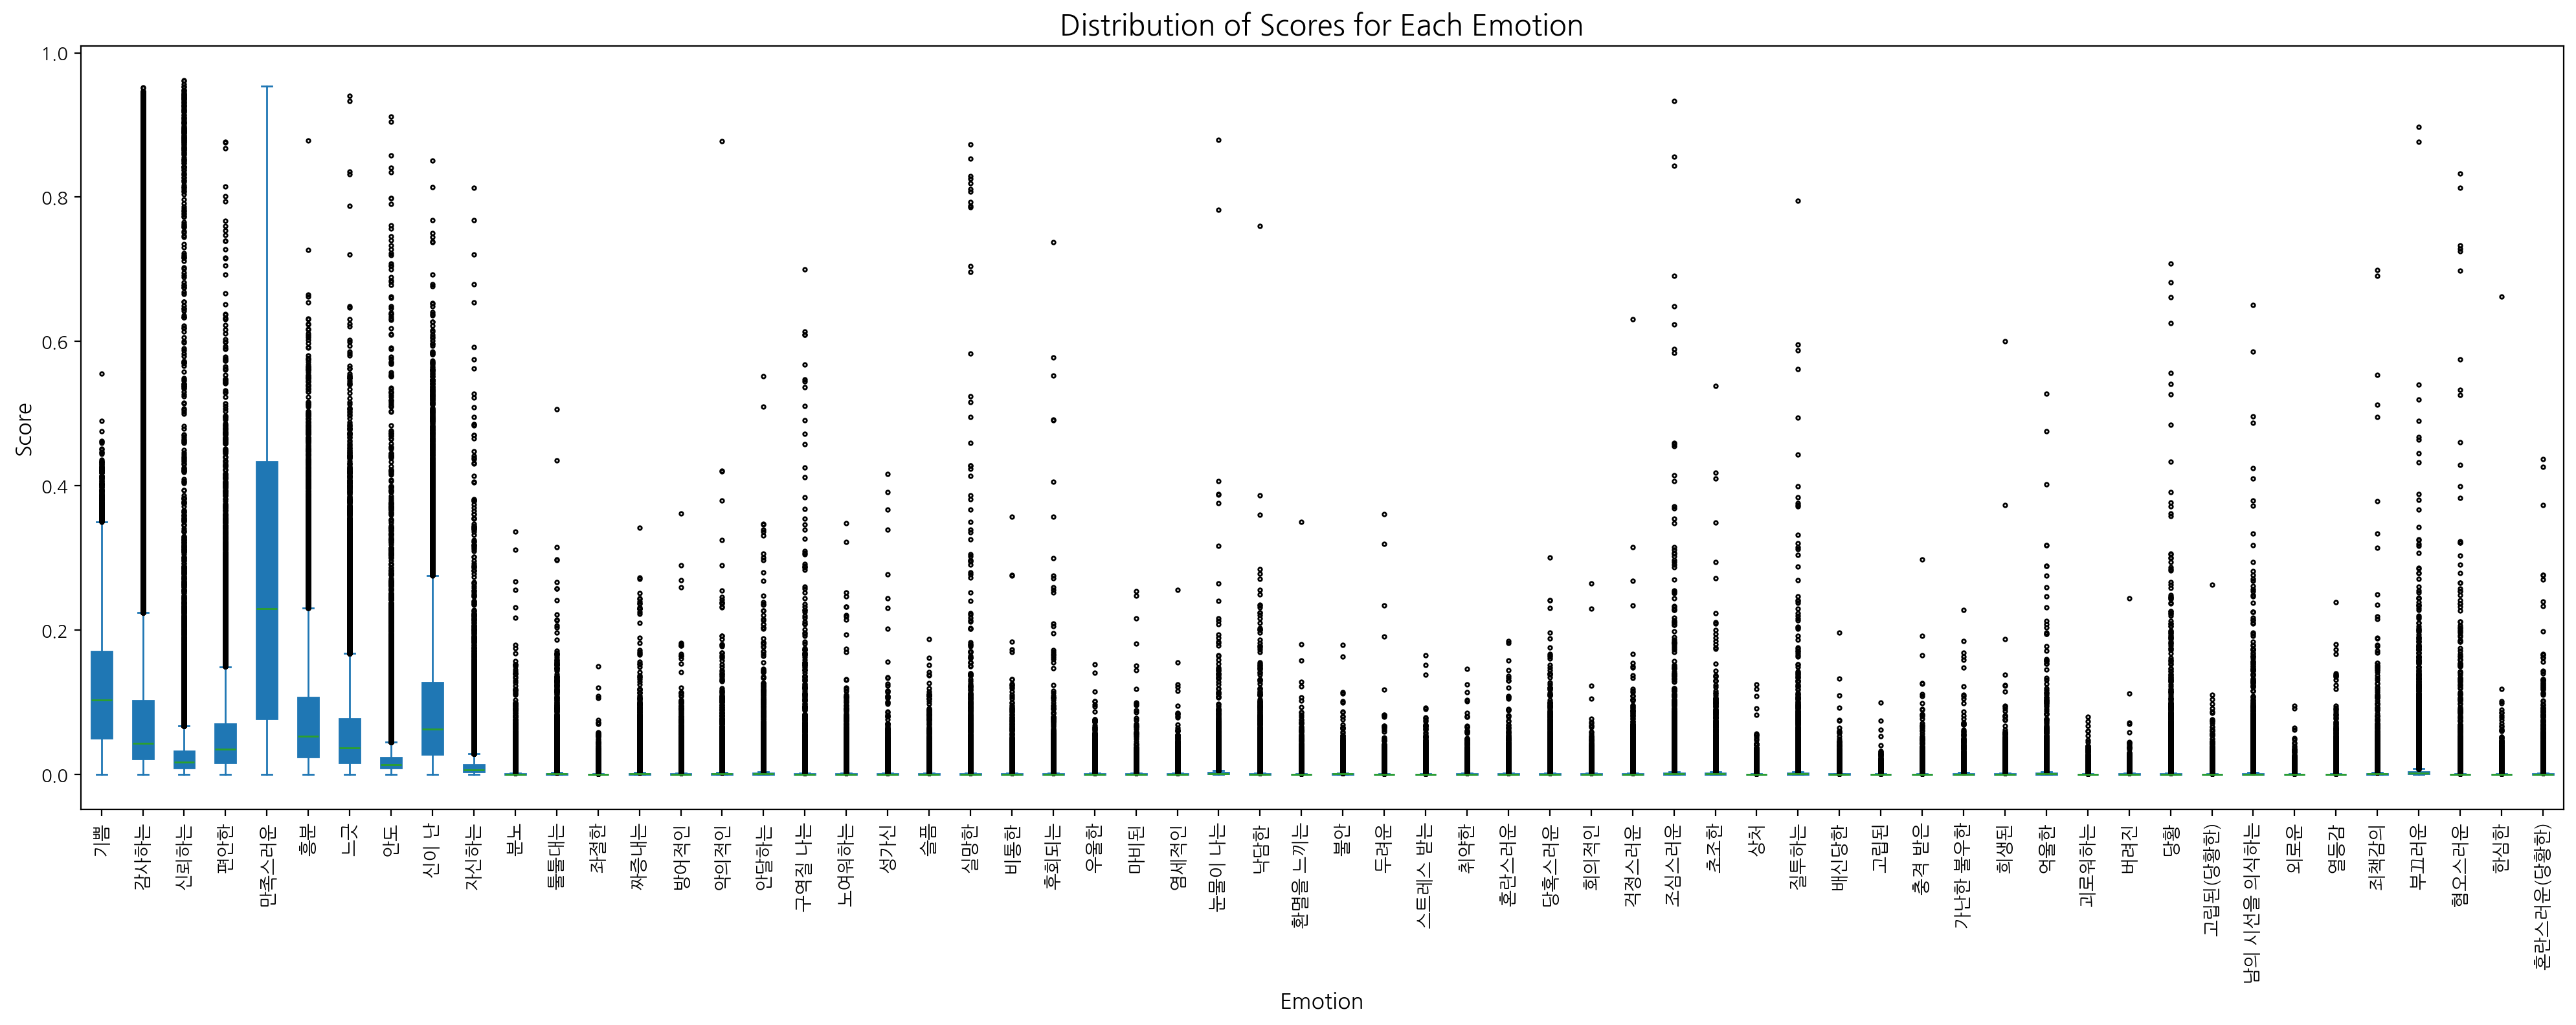

In [ ]:
import matplotlib.pyplot as plt

# 데이터프레임에서 감정 점수 컬럼들만 추출 (감정 이름 컬럼들)
emotion_columns = data.columns[8:68]  # 앞 8개는 리뷰 관련 데이터

# 점 크기 조정
flierprops = dict(marker='o', markersize=2, linestyle='none', markeredgecolor='black')

# 박스플롯 생성
plt.figure(figsize=(20, 8))
data[emotion_columns].plot(kind='box', figsize=(20, 8), vert=True, patch_artist=True, flierprops=flierprops)

# 그래프 제목과 축 레이블 설정
plt.title('Distribution of Scores for Each Emotion', fontsize=16)
plt.xlabel('Emotion', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xticks(rotation=90)  # 감정 이름 회전

# 그래프 레이아웃 조정
plt.tight_layout()

# 그래프 출력
plt.show()


In [ ]:
data.iloc[:, 8:68]

,기쁨,감사하는,신뢰하는,편안한,만족스러운,흥분,느긋,안도,신이 난,자신하는,...,당황,고립된(당황한),남의 시선을 의식하는,외로운,열등감,죄책감의,부끄러운,혐오스러운,한심한,혼란스러운(당황한)
0,0.050241,0.015109,0.013506,0.014360,0.091871,0.172507,0.089853,0.013428,0.193094,0.029927,...,0.003105,0.002228,0.004319,0.000711,0.011530,0.002790,0.011338,0.002199,0.002913,0.001388
1,0.398738,0.166094,0.018941,0.093999,0.087075,0.053336,0.015554,0.065210,0.073326,0.007232,...,0.000298,0.000178,0.000185,0.000170,0.000142,0.000780,0.001646,0.000212,0.000159,0.000400
2,0.002643,0.001741,0.001116,0.004332,0.007486,0.010619,0.003405,0.001713,0.006171,0.003279,...,0.005065,0.002921,0.031113,0.000969,0.028056,0.007313,0.016509,0.073895,0.011734,0.001859
3,0.061099,0.824161,0.009333,0.012068,0.012235,0.024802,0.004235,0.006728,0.029375,0.001091,...,0.000333,0.000139,0.000219,0.000082,0.000122,0.000693,0.000911,0.000174,0.000316,0.000407
4,0.009659,0.003071,0.007952,0.007126,0.013329,0.025135,0.012152,0.010840,0.020438,0.022650,...,0.001247,0.004043,0.002202,0.001904,0.003008,0.003552,0.001977,0.002752,0.003676,0.002022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21995,0.070066,0.598584,0.035560,0.074998,0.060878,0.018990,0.030823,0.034059,0.047447,0.002162,...,0.000719,0.000300,0.000576,0.000235,0.000174,0.001886,0.002168,0.000879,0.001087,0.000454
21996,0.160321,0.388837,0.012292,0.027215,0.107611,0.109027,0.026844,0.009721,0.129606,0.002212,...,0.000653,0.000208,0.000310,0.000133,0.000239,0.000760,0.001542,0.000469,0.000364,0.000500
21997,0.122369,0.037527,0.016590,0.067331,0.470909,0.042471,0.116227,0.014140,0.071608,0.005262,...,0.000872,0.000294,0.000671,0.000337,0.000172,0.000864,0.002953,0.000291,0.000313,0.000466
21998,0.162626,0.482899,0.005107,0.012483,0.046818,0.094459,0.010676,0.010703,0.147127,0.001370,...,0.000470,0.000152,0.000424,0.000108,0.000215,0.000992,0.001770,0.000327,0.000272,0.000409


In [ ]:
from scipy.stats import entropy

# 감정 점수를 정규화 (각 리뷰의 합이 1로 유지되도록)
emotion_scores = data.iloc[:, 8:68]  # 감정 컬럼만 선택
normalized_scores = emotion_scores.div(emotion_scores.sum(axis=1), axis=0)

# 엔트로피 계산
data['entropy'] = normalized_scores.apply(lambda x: entropy(x + 1e-10), axis=1)

# 결과 확인
print(data[['split_texts', 'entropy']].head())


                                         split_texts   entropy
0  봄 지나 여름 여름 지나 가을이 오고 부쩍 날이 쌀쌀해진 요즘 몸이 허해진 찰나 직...  3.065101
1                         훈련간 아들이 보내준 선물 감동감동 빨리 나을게  1.952236
2  포장고급스럽다하는데 걍 부직포인데키링에 오쏘몰 대문짝만하게 있어서 달고다니면 오쏘몰...  3.178659
3  우리팀의 보배 김대리님 입사한지 이제 100일 정도 되었는데 일 잘하는것도 너무 감...  0.857784
4  체력이 딸려서 힘들 때마다 먹고있어요 요단강에 발 담구고 있는데 현실 세계로 멱살잡...  3.523872


엔트로피가 높을수록 리뷰가 여러 감정을 반영한다고 볼 수 있음.

- 단일 감정 지배 (Low Entropy):
  - 특정 감정 점수가 매우 높고, 나머지 감정은 거의 0에 가까운 경우.
  - 리뷰에 특정 감정이 강하게 나타나는 경우를 의미.
  - 예: 엔트로피 값 ≈ 0.2~1.0
- 다양한 감정 등장 (High Entropy):
  - 여러 감정 점수가 비슷한 수준으로 분산된 경우.
  - 리뷰가 다양한 감정을 반영.
  - 예: 엔트로피 값 ≈ 2.5~4.0

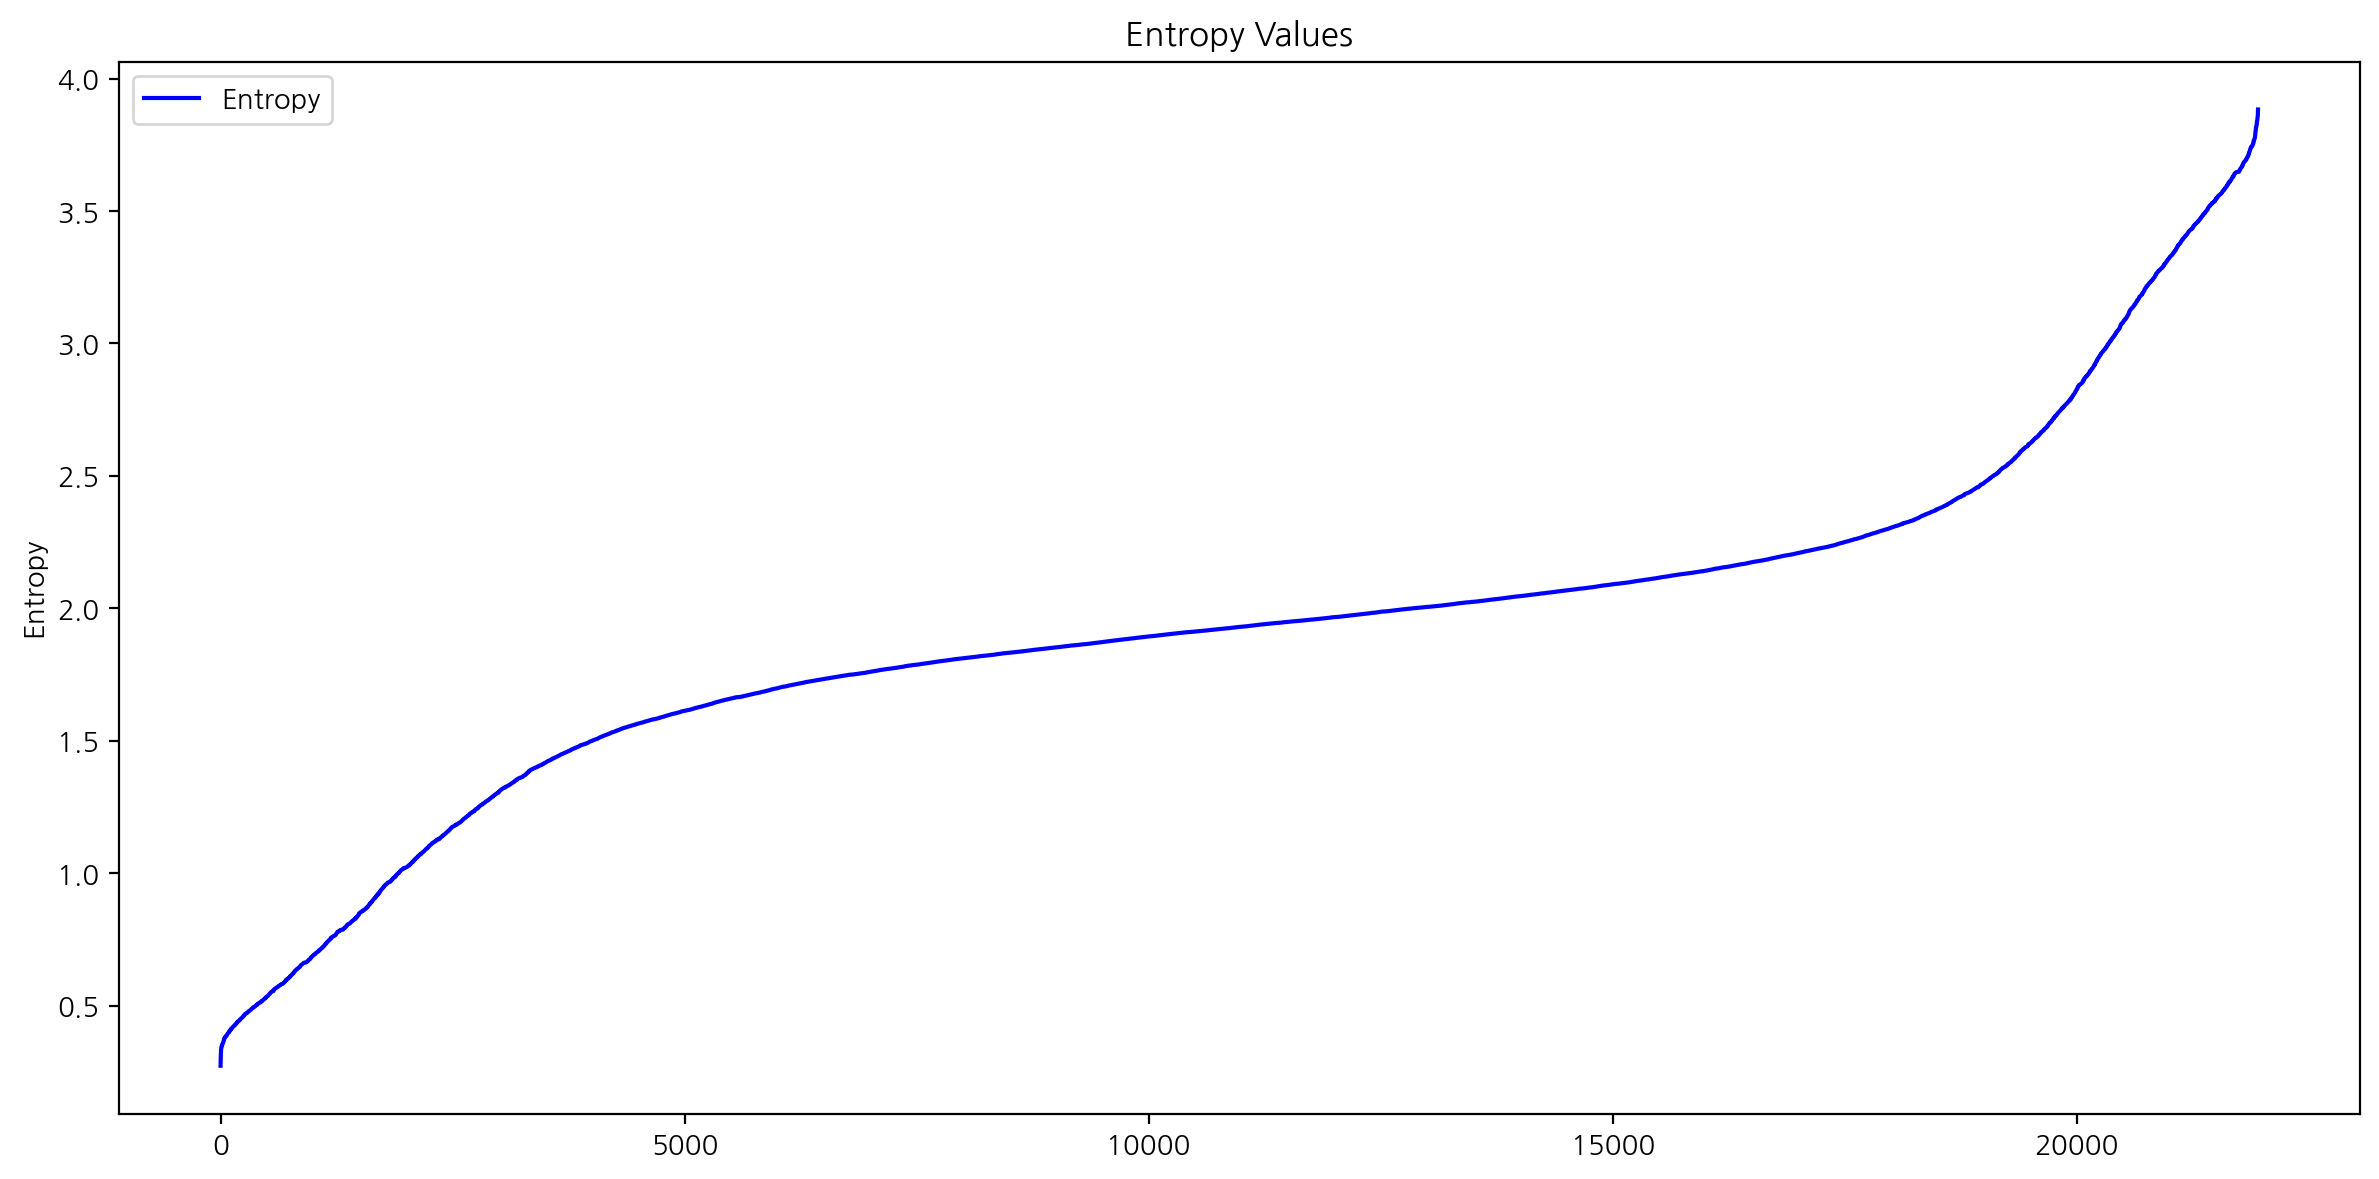

In [ ]:
# entropy 열 값을 낮은 값부터 정렬
sorted_entropy = data['entropy'].sort_values().reset_index(drop=True)

# 꺾은선 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(sorted_entropy, linestyle='-', markersize=2, color='blue', label='Entropy')

# 그래프 제목과 축 레이블 설정
plt.title('Entropy Values', fontsize=12)
plt.ylabel('Entropy', fontsize=10)

# 범례 추가
plt.legend()

# 그래프 출력
plt.tight_layout()
plt.show()

In [ ]:
# entropy 높은 순으로 5개 행 추출
high_entropy = data.nlargest(15, 'entropy')[['split_texts', 'entropy']]

# entropy 낮은 순으로 5개 행 추출
low_entropy = data.nsmallest(15, 'entropy')[['split_texts', 'entropy']]

In [ ]:
# 다양한 감정 등장 (High Entropy)
print("Top 15 High Entropy Rows:")
high_entropy

Top 15 High Entropy Rows:


,split_texts,entropy
11678,어디서많이맡아본향 전남친향수냄새,3.883370
1905,3,3.870693
5407,the perfect lip balm which I have received,3.859852
12043,건강하게 먹어봅시다,3.858270
15133,너무 앗있어요,3.857806
11079,튼살 예방 이 잘되었으면 좋겠어요,3.854922
3344,아직 먹지 않아서 맛은 몰라요,3.853582
7933,꾸덕꾸덕한 초코를 맛보고싶다면 고디바로,3.844123
19296,잘 받 았 습 니 다,3.841893
13055,사과맛이네요 아이가 맛있대요 쫄깃한맛이 아니고 뚝뚝 끊어지고 달아요,3.839001


In [ ]:
# 단일 감정 지배 (Low Entropy)
print("\nTop 15 Low Entropy Rows:")
low_entropy


Top 15 Low Entropy Rows:


,split_texts,entropy
8170,요즘 비건에 관심이 많은데 제품 성분도 착한데 포장지며 환경을 생각한 브랜드라 더 ...,0.273623
20902,정관장 믿을수 있고 신뢰가 가는 거라 선물로 너무 좋아요,0.293607
3918,남여로 구분된 영양제라 서로에게 필요한대로 고를수있어 신뢰가 가네요,0.308420
4419,정말 최고입니다맛나게 보이고 남편 선물로 받았습니다역시 한우는 농협 안심이 믿...,0.315154
7032,말로만 듣던 달바 제품을 이번 생일 선물로 받아 써봤어요 보통 크림 타입의 세럼은 ...,0.325577
2141,헤라 립밤은 처음인데 너무 만족스러워요 선물해 준 친구야 고마워,0.332904
13851,역시 믿고 쓰는 브랜드 너무너무 좋아요,0.335825
13874,생일 선물로 받았는데 매우 만족스러워요,0.338303
10289,선물로 받았는데 아주 만족스럽습니다,0.339741
9829,건강하고 마음에 쏙 드는 선물입니다 대단히 만족합니다,0.341290


Knee Point Index: 18469, Entropy Value: 2.368187916787688


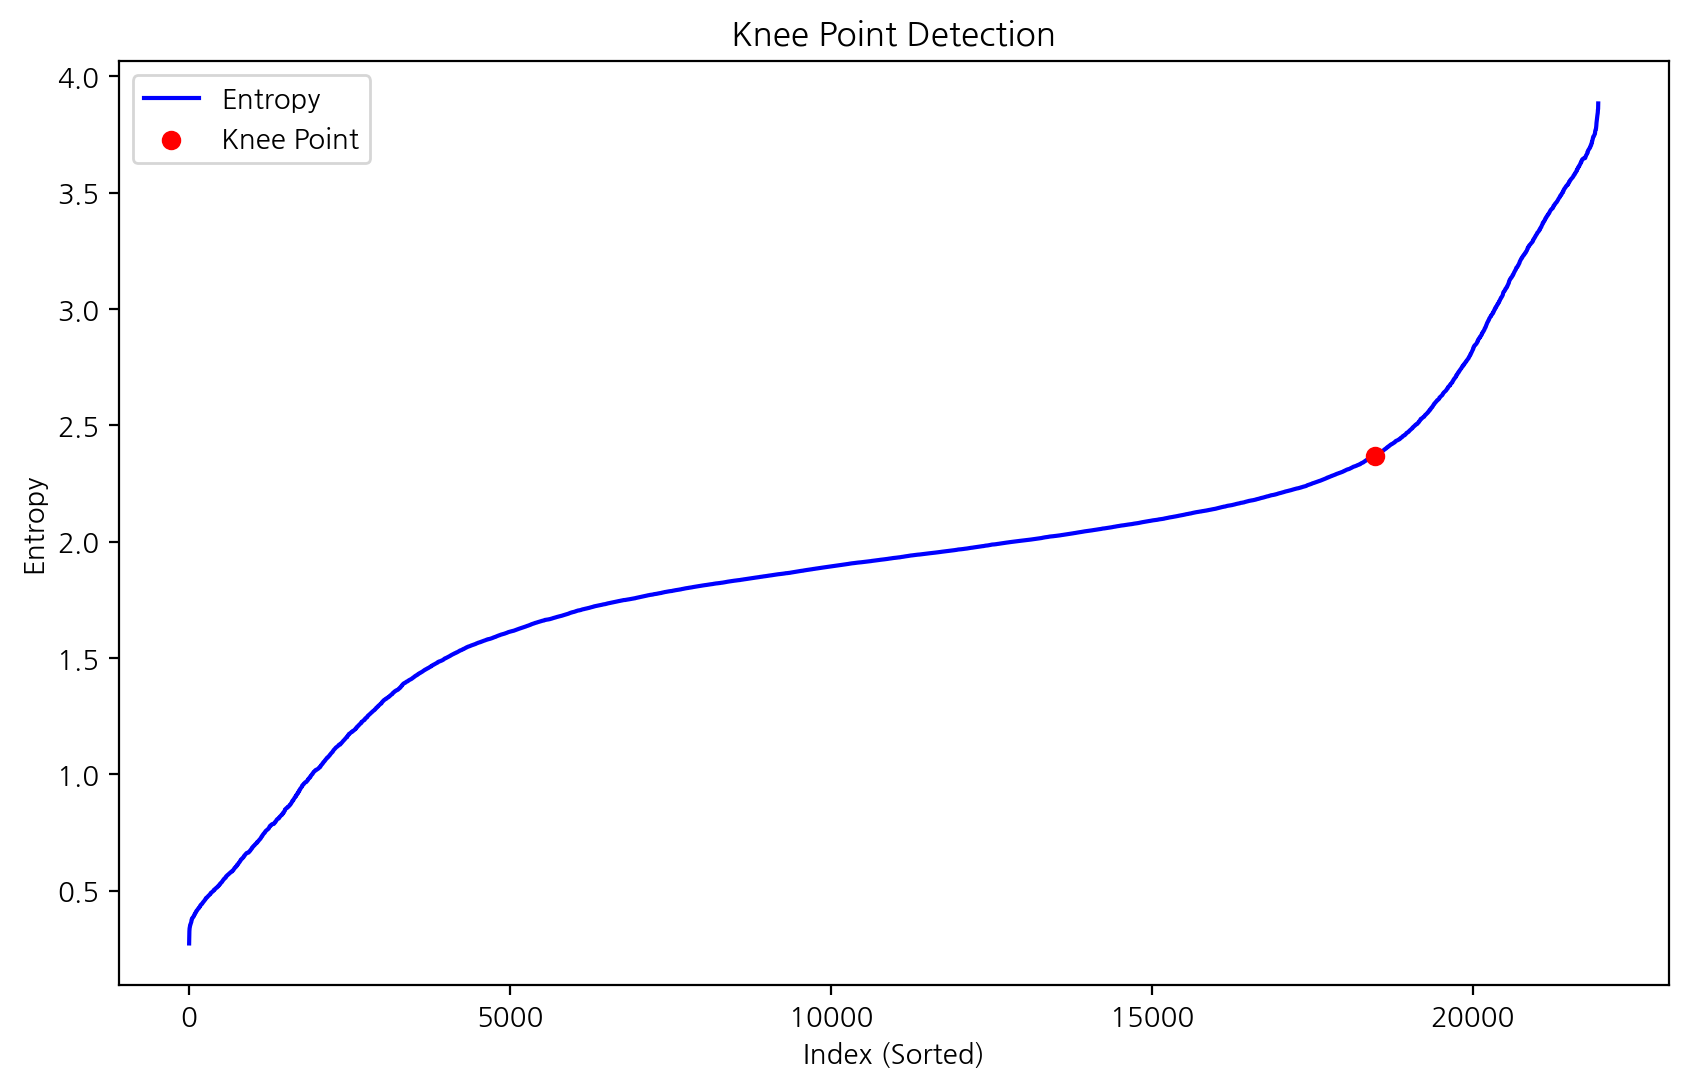

In [ ]:
# 엘보우 포인트 찾기

from scipy.spatial.distance import cdist

# 정렬된 엔트로피 값 가져오기
sorted_entropy = data['entropy'].sort_values().reset_index(drop=True)

# x 좌표 생성
x = np.arange(len(sorted_entropy))

# 시작점과 끝점 정의
start = np.array([x[0], sorted_entropy.iloc[0]])
end = np.array([x[-1], sorted_entropy.iloc[-1]])

# 모든 점과 시작-끝 직선 사이의 거리 계산
distances = np.abs(np.cross(end - start, np.array([x, sorted_entropy]).T - start)) / np.linalg.norm(end - start)

# 최대 거리의 인덱스 찾기
knee_point = np.argmax(distances)

# 꺾이는 지점 출력
print(f"Knee Point Index: {knee_point}, Entropy Value: {sorted_entropy.iloc[knee_point]}")

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(x, sorted_entropy, label='Entropy', color='blue')
plt.scatter(knee_point, sorted_entropy.iloc[knee_point], color='red', label='Knee Point', zorder=5)
plt.xlabel('Index (Sorted)')
plt.ylabel('Entropy')
plt.title('Knee Point Detection')
plt.legend()
plt.show()


In [ ]:
# 엔트로피가 1.2612705845940677 일때를 임계점으로 두고,
# 각각의 리뷰에 대해 감정 개수가 몇개 포함되는지 알아내서 새로운 컬럼에 emotion_num 추가하는 코드

In [ ]:
# 임계값 설정
threshold = 0.001

# 감정 개수 계산
data['emotion_num'] = data.iloc[:, 8:68].apply(lambda row: (row > threshold).sum(), axis=1)

# 결과 확인
print(data[['split_texts', 'emotion_num']].head())

                                         split_texts  emotion_num
0  봄 지나 여름 여름 지나 가을이 오고 부쩍 날이 쌀쌀해진 요즘 몸이 허해진 찰나 직...           59
1                         훈련간 아들이 보내준 선물 감동감동 빨리 나을게           12
2  포장고급스럽다하는데 걍 부직포인데키링에 오쏘몰 대문짝만하게 있어서 달고다니면 오쏘몰...           59
3  우리팀의 보배 김대리님 입사한지 이제 100일 정도 되었는데 일 잘하는것도 너무 감...           11
4  체력이 딸려서 힘들 때마다 먹고있어요 요단강에 발 담구고 있는데 현실 세계로 멱살잡...           60


In [ ]:
data[['split_texts', 'emotion_num']].head(10)

,split_texts,emotion_num
0,봄 지나 여름 여름 지나 가을이 오고 부쩍 날이 쌀쌀해진 요즘 몸이 허해진 찰나 직...,59
1,훈련간 아들이 보내준 선물 감동감동 빨리 나을게,12
2,포장고급스럽다하는데 걍 부직포인데키링에 오쏘몰 대문짝만하게 있어서 달고다니면 오쏘몰...,59
3,우리팀의 보배 김대리님 입사한지 이제 100일 정도 되었는데 일 잘하는것도 너무 감...,11
4,체력이 딸려서 힘들 때마다 먹고있어요 요단강에 발 담구고 있는데 현실 세계로 멱살잡...,60
5,중요한 시험을 앞둔 저에게 친구가 응원 선물로 보내주었어요 떨어지면 큰일 나겠다는 ...,60
6,제자야 선물 고맙고 비타민 먹고 선생님 힘 낼게 그리고 겨울 방학되면 학교에 한 번...,55
7,딸래미가 타지에서 보내온 생일선물 잘 받았습니다,13
8,비타민 챙겨줘서 고마워,14
9,한번 먹으렸는데 서울조카가 보냈습니다 정을 생각하면 벌써 건강을 눈앞에 둔 느낌이 듭니다,26


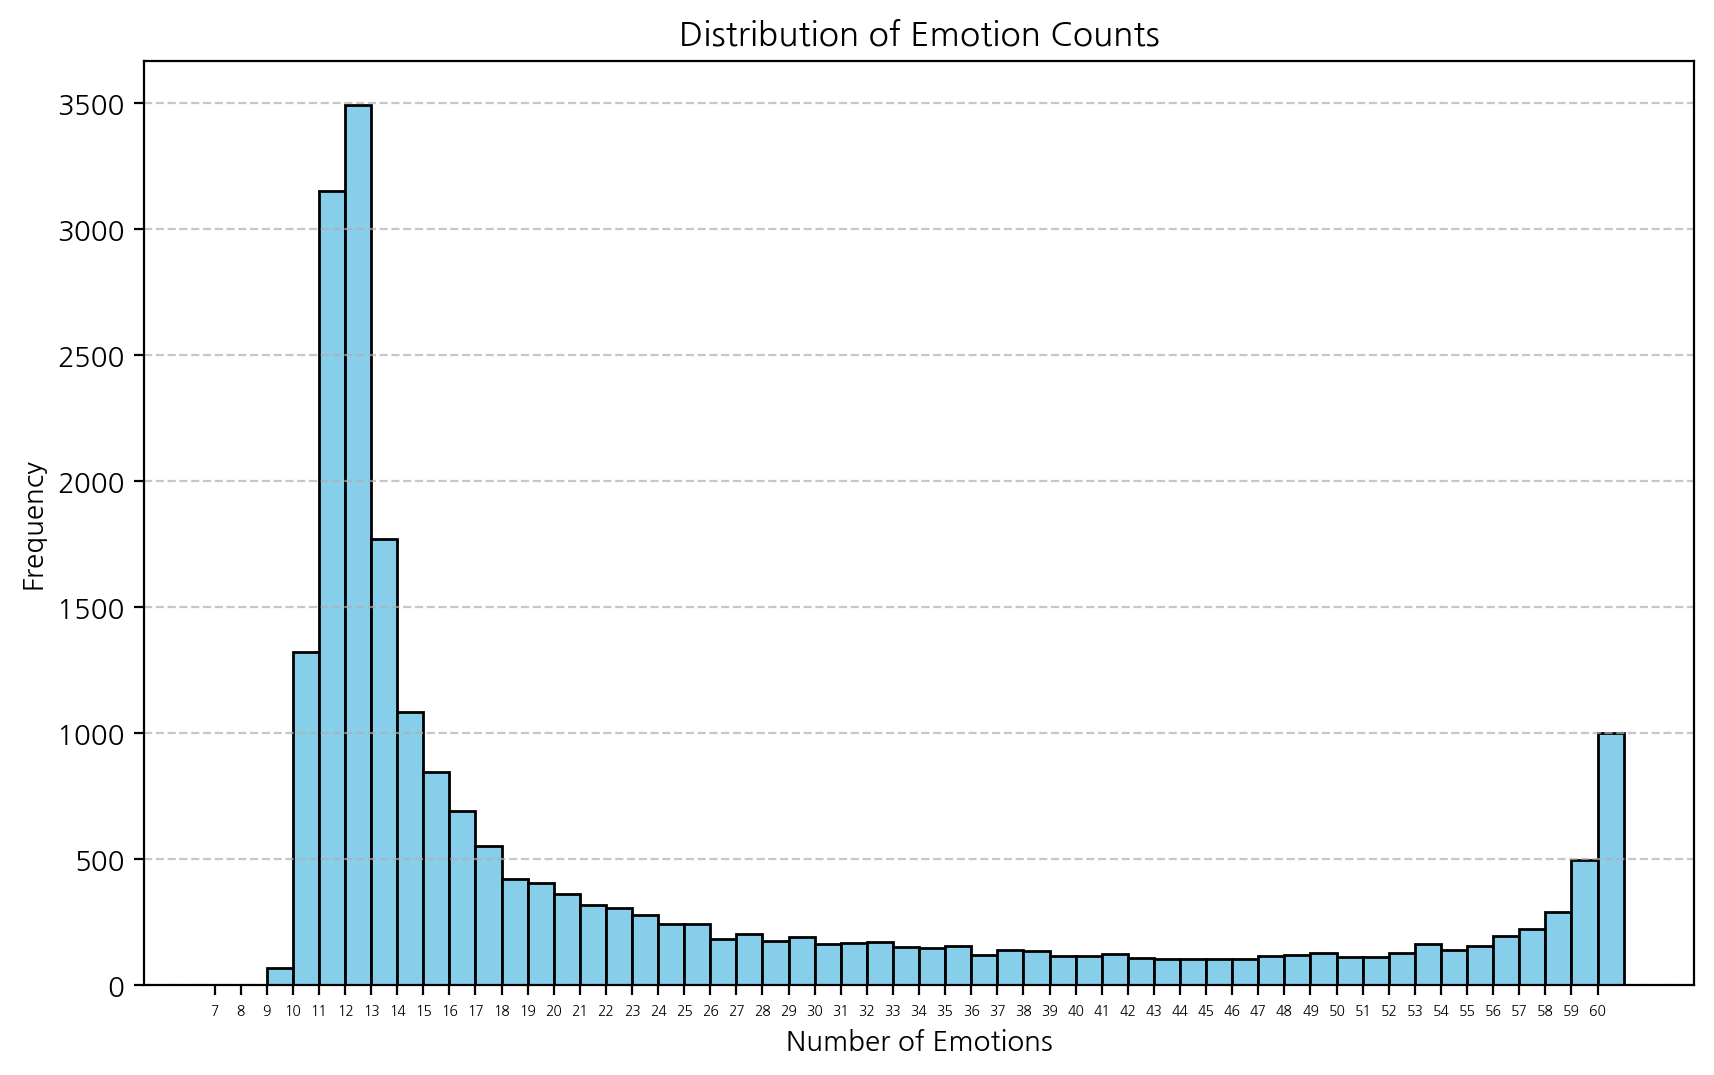

In [ ]:
# 히스토그램으로 emotion_num 분포 시각화
plt.figure(figsize=(10, 6))
plt.hist(data['emotion_num'], bins=range(data['emotion_num'].min(),
                                         data['emotion_num'].max() + 2),
         color='skyblue', edgecolor='black')
plt.title('Distribution of Emotion Counts', fontsize=12)
plt.xlabel('Number of Emotions', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.xticks(range(data['emotion_num'].min(), data['emotion_num'].max() + 1), fontsize=5)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
# 회귀분석을 위한 데이터셋 정리

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21955 entries, 0 to 21999
Data columns (total 70 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            21955 non-null  int64  
 1   Title         21955 non-null  object 
 2   score         21954 non-null  float64
 3   username      21955 non-null  object 
 4   date          21955 non-null  object 
 5   giver         21955 non-null  object 
 6   review_likes  21955 non-null  int64  
 7   split_texts   21955 non-null  object 
 8   기쁨            21955 non-null  float64
 9   감사하는          21955 non-null  float64
 10  신뢰하는          21955 non-null  float64
 11  편안한           21955 non-null  float64
 12  만족스러운         21955 non-null  float64
 13  흥분            21955 non-null  float64
 14  느긋            21955 non-null  float64
 15  안도            21955 non-null  float64
 16  신이 난          21955 non-null  float64
 17  자신하는          21955 non-null  float64
 18  분노            21955 non-null  f

### 회귀 분석은 R에서 하는걸로 !!

- 독립 변수 : 선물 준 사람과 수령인의 관계 (수직적 vs. 수평적 vs. 자기 선물)
- 종속 변수 `다중 종속 모델`
    - 리뷰 공감도 (리뷰 공감 수)
    - 선물 만족도 (리뷰 평점 + BERT 감성 분석 가중치)
- 매개 변수
    - 리뷰 감정 다양성 (리뷰 텍스트 분석 후 감정 카테고리 수)
- 통제 변수
    - 리뷰 작성일 : 특정 시기나 이벤트에 따른 선물 트렌드 변화의 영향을 통제
    - 리뷰 작성자의 익명 여부 : 익명성이 리뷰의 솔직성에 미치는 영향을 통제
    - 리뷰 길이 : 리뷰가 길어질수록 다양한 감정을 표현할 가능성을 통제

1. 선물 만족도 파생변수 생성

In [ ]:
# '기쁨'부터 '자신하는'까지 감정 점수 합계 계산
satis_emotions = ["기쁨", "감사하는", "신뢰하는", "편안한", "만족스러운", "흥분", "느긋", "안도", "신이 난", "자신하는"]
data['satis_score'] = data[satis_emotions].sum(axis=1)

# 선물 만족도 계산
data['present_score'] = (data['score'] * 0.5) + (data['satis_score'] * 0.5)

2. 리뷰 작성일 변환

리뷰 작성일을 날짜 타입으로 변환하고 연도, 월, 분기 정보 추가

In [ ]:
# 리뷰 작성일 변환
data['date'] = pd.to_datetime(data['date'], format='%Y.%m.%d')

# 연도, 월, 분기 정보 추가
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['quarter'] = data['date'].dt.quarter

3. 데이터프레임 Join

data에 giver_label과 anonymity 컬럼 추가

In [ ]:
# 데이터프레임 Join
data = data.merge(df[['ID', 'giver_label', 'anonymity']], on='ID', how='left')

4. 리뷰 길이 변수 생성

In [ ]:
# 텍스트 리뷰 길이 계산
data['review_length'] = data['Title'].str.len()

In [ ]:
data

,ID,Title,score,username,date,giver,review_likes,split_texts,기쁨,감사하는,...,entropy,emotion_num,satis_score,present_score,year,month,quarter,giver_label,anonymity,review_length
0,1,"봄 지나 여름, 여름 지나 가을이 오고 부쩍 날이 쌀쌀해진 요즘 몸이 허해진 찰나 ...",4.0,다정한 콘,2023-09-15,제자,1417,봄 지나 여름 여름 지나 가을이 오고 부쩍 날이 쌀쌀해진 요즘 몸이 허해진 찰나 직...,0.050241,0.015109,...,1.311897,59,0.683895,2.341948,2023,9,3,vertical,익명,701
1,2,훈련간 아들이 보내준 선물.\r\n감동+감동~\r\n빨리 나을게^^,4.0,기뻐하는 튜브,2023-07-31,부모님,95,훈련간 아들이 보내준 선물 감동감동 빨리 나을게,0.398738,0.166094,...,1.301461,12,0.979504,2.489752,2023,7,3,etc,익명,33
2,3,"포장고급스럽다하는데 걍 부직포인데,,키링에 오쏘몰 대문짝만하게 있어서 달고다니면 오...",3.0,행복한 어피치,2023-12-28,친구,37,포장고급스럽다하는데 걍 부직포인데키링에 오쏘몰 대문짝만하게 있어서 달고다니면 오쏘몰...,0.002643,0.001741,...,1.310973,59,0.042506,1.521253,2023,12,4,horizontal,익명,124
3,4,"우리팀의 보배 김대리님~♡\r\n입사한지 이제 100일 정도 되었는데,\r\n일 잘...",4.0,유영미,2024-02-07,직장동료,22,우리팀의 보배 김대리님 입사한지 이제 100일 정도 되었는데 일 잘하는것도 너무 감...,0.061099,0.824161,...,1.151938,11,0.985129,2.492564,2024,2,1,vertical,실명,119
4,5,체력이 딸려서 힘들 때마다 먹고있어요. 요단강에 발 담구고 있는데 현실 세계로 멱살...,4.0,다정한 라이언,2023-02-01,친구,395,체력이 딸려서 힘들 때마다 먹고있어요 요단강에 발 담구고 있는데 현실 세계로 멱살잡...,0.009659,0.003071,...,1.307184,60,0.132353,2.066177,2023,2,1,horizontal,익명,58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21950,21996,빠른배송 감사합니다!!\r\n잘 먹겠습니다!!,4.0,명랑한 앙몬드,2023-11-18,선/후배,1,빠른배송 감사합니다 잘 먹겠습니다,0.070066,0.598584,...,1.283637,16,0.973566,2.486783,2023,11,4,vertical,익명,23
21951,21997,빠른 배송에 놀랐고 신선함에 다시 한번 놀랐습니다. 덕분에 새콤달콤한 명절 보내게되...,4.0,다정한 콘,2023-09-27,기타,2,빠른 배송에 놀랐고 신선함에 다시 한번 놀랐습니다 덕분에 새콤달콤한 명절 보내게되어...,0.160321,0.388837,...,1.299751,12,0.973687,2.486843,2023,9,3,etc,익명,68
21952,21998,선물 받았는데~~새콤달콤하니 맛있어요~~~,4.0,💕,2023-11-17,형제/자매,1,선물 받았는데새콤달콤하니 맛있어요,0.122369,0.037527,...,1.299216,21,0.964434,2.482217,2023,11,4,horizontal,실명,23
21953,21999,깔끔하게 포장되어 내게로온 타이벡귤\r\n넘나 달고 맛나서 순식간에 한상자 비우고\...,4.0,친절한 콘,2023-11-17,기타,1,깔끔하게 포장되어 내게로온 타이벡귤 넘나 달고 맛나서 순식간에 한상자 비우고 나머지...,0.162626,0.482899,...,1.286882,13,0.974269,2.487134,2023,11,4,self,익명,72


## [4] Review 와 Product 데이터셋 JOIN

In [ ]:
# 데이터 로드

# 파일 경로
file_path = '/content/drive/MyDrive/Business Analytics 석사/24-2 [수업] 비즈니스 머신러닝/'

# 파일 로드
review_df = pd.read_excel(file_path + 'review-ALL.xlsx')
product_df = pd.read_excel(file_path + 'Product_ALL.xlsx')

In [ ]:
review_df.head()

,ID,Title,Image,ico_detail,View,View1,Keywords,Info,Description,Description3,Description4,Description5,ico_detail6,Page_URL
0,1,"봄 지나 여름, 여름 지나 가을이 오고 부쩍 날이 쌀쌀해진 요즘 몸이 허해진 찰나 ...",https://gift-s.kakaocdn.net/dn/gift/gift/con.png,별점 4점 만점 중 4점,다정한 콘,2023.09.15,#제자에게 받은\n#반려동물 선물,"총 1,417명이 공감했어요!","재미있어요\n공감수 :\n1,247\n개,","감동이에요\n공감수 :\n87\n개,","받고 싶어요\n공감수 :\n47\n개,","속상해요\n공감수 :\n36\n개,",리뷰 관련 메뉴,https://gift.kakao.com/product/2301047?tab=rev...
1,2,훈련간 아들이 보내준 선물.\n감동+감동~\n빨리 나을게^^,https://gift-s.kakaocdn.net/dn/gift/gift/tube.png,별점 4점 만점 중 4점,기뻐하는 튜브,2023.07.31,#부모님에게 받은\n#위로 선물,총 95명이 공감했어요!,"감동이에요\n공감수 :\n81\n개,","받고 싶어요\n공감수 :\n7\n개,","속상해요\n공감수 :\n5\n개,","재미있어요\n공감수 :\n2\n개,",리뷰 관련 메뉴,https://gift.kakao.com/product/2301047?tab=rev...
2,3,"포장고급스럽다하는데 걍 부직포인데,,키링에 오쏘몰 대문짝만하게 있어서 달고다니면 오...",https://gift-s.kakaocdn.net/dn/gift/gift/apeac...,별점 4점 만점 중 3점,행복한 어피치,2023.12.28,#친구에게 받은\n#응원 선물,총 37명이 공감했어요!,"재미있어요\n공감수 :\n25\n개,","속상해요\n공감수 :\n8\n개,","감동이에요\n공감수 :\n2\n개,","받고 싶어요\n공감수 :\n2\n개,",리뷰 관련 메뉴,https://gift.kakao.com/product/2301047?tab=rev...
3,4,"우리팀의 보배 김대리님~♡\n입사한지 이제 100일 정도 되었는데,\n일 잘하는것도...",https://p.kakaocdn.net/th/talkp/wo9jhOMK05/8rp...,별점 4점 만점 중 4점,유영미,2024.02.07,#직장동료에게 받은\n#생일 선물,총 22명이 공감했어요!,"감동이에요\n공감수 :\n15\n개,","받고 싶어요\n공감수 :\n6\n개,","재미있어요\n공감수 :\n1\n개,","속상해요\n공감수 :\n0\n개,",리뷰 관련 메뉴,https://gift.kakao.com/product/2301047?tab=rev...
4,5,체력이 딸려서 힘들 때마다 먹고있어요. 요단강에 발 담구고 있는데 현실 세계로 멱살...,https://gift-s.kakaocdn.net/dn/gift/gift/ryan.png,별점 4점 만점 중 4점,다정한 라이언,2023.02.01,#친구에게 받은\n#생일 선물,총 395명이 공감했어요!,"재미있어요\n공감수 :\n338\n개,","감동이에요\n공감수 :\n22\n개,","속상해요\n공감수 :\n18\n개,","받고 싶어요\n공감수 :\n17\n개,",리뷰 관련 메뉴,https://gift.kakao.com/product/2301047?tab=rev...


In [ ]:
product_df.head()

,name,ranking,brand,price,exclusive,URL
0,"""독일 명품 비타민"" 오쏘몰 이뮨 멀티비타민&미네랄 7입 - 단독 기프트박스 증정 ...",1,오쏘몰,"38,000원",NaN,https://gift.kakao.com/product/2301047
1,"""독일 오쏘몰 신제품"" NEW 오쏘몰 바이탈 m/f 남성/여성 선택가능 7입 - 고...",2,오쏘몰,"29,900원",NaN,https://gift.kakao.com/product/9863377
2,"""한국인 맞춤 비타민"" 옵티마 이뮨 멀티비타민&미네랄 10입 / 1박스 + 네잎클로...",3,더블유젯바이오,"29,900원",NaN,https://gift.kakao.com/product/7608679
3,[각인/선물포장] NEW 립 글로우,4,디올,"50,000원",NaN,https://gift.kakao.com/product/2259144
4,[단독]푸드장 프리미엄 구이 선물세트1.15kg(부채살+살치살+토시살+소목등심(척아...,5,푸드장,"49,900원",단독,https://gift.kakao.com/product/5259781


In [ ]:
# review_df에서 코드 추출
review_df['product_code'] = review_df['Page_URL'].str.extract(r'/product/(\d+)')

# product_df에서 코드 추출
product_df['product_code'] = product_df['URL'].str.extract(r'/product/(\d+)')

# 두 데이터프레임 병합
review_product_join = pd.merge(
    review_df[['ID', 'product_code']],
    product_df,
    on='product_code',
    how='inner'
)

# 결과 확인
print(review_product_join.head())

   ID product_code                                               name  \
0   1      2301047  "독일 명품 비타민" 오쏘몰 이뮨 멀티비타민&미네랄 7입 - 단독 기프트박스 증정 ...   
1   2      2301047  "독일 명품 비타민" 오쏘몰 이뮨 멀티비타민&미네랄 7입 - 단독 기프트박스 증정 ...   
2   3      2301047  "독일 명품 비타민" 오쏘몰 이뮨 멀티비타민&미네랄 7입 - 단독 기프트박스 증정 ...   
3   4      2301047  "독일 명품 비타민" 오쏘몰 이뮨 멀티비타민&미네랄 7입 - 단독 기프트박스 증정 ...   
4   5      2301047  "독일 명품 비타민" 오쏘몰 이뮨 멀티비타민&미네랄 7입 - 단독 기프트박스 증정 ...   

   ranking brand    price exclusive                                     URL  
0        1   오쏘몰  38,000원       NaN  https://gift.kakao.com/product/2301047  
1        1   오쏘몰  38,000원       NaN  https://gift.kakao.com/product/2301047  
2        1   오쏘몰  38,000원       NaN  https://gift.kakao.com/product/2301047  
3        1   오쏘몰  38,000원       NaN  https://gift.kakao.com/product/2301047  
4        1   오쏘몰  38,000원       NaN  https://gift.kakao.com/product/2301047  


In [ ]:
review_product_join.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22358 entries, 0 to 22357
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            22358 non-null  int64 
 1   product_code  22358 non-null  object
 2   name          22358 non-null  object
 3   ranking       22358 non-null  int64 
 4   brand         22358 non-null  object
 5   price         22358 non-null  object
 6   exclusive     7271 non-null   object
 7   URL           22358 non-null  object
dtypes: int64(2), object(6)
memory usage: 1.4+ MB


In [ ]:
# 필요한 컬럼만 선택
columns_to_merge = ['ID', 'product_code', 'name', 'ranking', 'brand', 'price', 'exclusive']

# 데이터 병합 (ID 기준)
data = pd.merge(
    data,
    review_product_join[columns_to_merge],
    on='ID',
    how='left'  # 'left'로 data에만 존재하는 ID도 유지
)

In [ ]:
# 결과 확인
data.head()

,ID,Title,score,username,date,giver,review_likes,split_texts,기쁨,감사하는,...,quarter,giver_label,anonymity,review_length,product_code,name,ranking,brand,price,exclusive
0,1,"봄 지나 여름, 여름 지나 가을이 오고 부쩍 날이 쌀쌀해진 요즘 몸이 허해진 찰나 ...",4.0,다정한 콘,2023-09-15,제자,1417,봄 지나 여름 여름 지나 가을이 오고 부쩍 날이 쌀쌀해진 요즘 몸이 허해진 찰나 직...,0.050241,0.015109,...,3,vertical,익명,701,2301047,"""독일 명품 비타민"" 오쏘몰 이뮨 멀티비타민&미네랄 7입 - 단독 기프트박스 증정 ...",1,오쏘몰,"38,000원",NaN
1,2,훈련간 아들이 보내준 선물.\r\n감동+감동~\r\n빨리 나을게^^,4.0,기뻐하는 튜브,2023-07-31,부모님,95,훈련간 아들이 보내준 선물 감동감동 빨리 나을게,0.398738,0.166094,...,3,etc,익명,33,2301047,"""독일 명품 비타민"" 오쏘몰 이뮨 멀티비타민&미네랄 7입 - 단독 기프트박스 증정 ...",1,오쏘몰,"38,000원",NaN
2,3,"포장고급스럽다하는데 걍 부직포인데,,키링에 오쏘몰 대문짝만하게 있어서 달고다니면 오...",3.0,행복한 어피치,2023-12-28,친구,37,포장고급스럽다하는데 걍 부직포인데키링에 오쏘몰 대문짝만하게 있어서 달고다니면 오쏘몰...,0.002643,0.001741,...,4,horizontal,익명,124,2301047,"""독일 명품 비타민"" 오쏘몰 이뮨 멀티비타민&미네랄 7입 - 단독 기프트박스 증정 ...",1,오쏘몰,"38,000원",NaN
3,4,"우리팀의 보배 김대리님~♡\r\n입사한지 이제 100일 정도 되었는데,\r\n일 잘...",4.0,유영미,2024-02-07,직장동료,22,우리팀의 보배 김대리님 입사한지 이제 100일 정도 되었는데 일 잘하는것도 너무 감...,0.061099,0.824161,...,1,vertical,실명,119,2301047,"""독일 명품 비타민"" 오쏘몰 이뮨 멀티비타민&미네랄 7입 - 단독 기프트박스 증정 ...",1,오쏘몰,"38,000원",NaN
4,5,체력이 딸려서 힘들 때마다 먹고있어요. 요단강에 발 담구고 있는데 현실 세계로 멱살...,4.0,다정한 라이언,2023-02-01,친구,395,체력이 딸려서 힘들 때마다 먹고있어요 요단강에 발 담구고 있는데 현실 세계로 멱살잡...,0.009659,0.003071,...,1,horizontal,익명,58,2301047,"""독일 명품 비타민"" 오쏘몰 이뮨 멀티비타민&미네랄 7입 - 단독 기프트박스 증정 ...",1,오쏘몰,"38,000원",NaN


In [ ]:
data.to_csv('/content/drive/MyDrive/Business Analytics 석사/24-2 [수업] 비즈니스 머신러닝/kakao_merge_dataset.csv', index=False)